In [1]:
import numpy

import rscha2d
import fibonacci_sphere
import trig
import constants
import coords
import gauge
import geofield
import xyzfield

from matplotlib import pyplot, colors, ticker
import matplotlib
%matplotlib nbagg
matplotlib.rcParams["font.family"] = "Fira Sans"
matplotlib.rcParams.update({'font.size': 10})

In [2]:
#lets do a thing to the data

#fname = "../data/db_q_septiembre17.csv"
fname = "../data/rscha2d/db_naveg_oct.csv"

In [3]:
#savepath = "../data/rscha2d/quality_nw"
savepath = "../data/rscha2d/all_nw"

In [4]:
lat_c = 42.0
lon_c = 20.0
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-lat_c, lon_c, 26.0, 50.0))
knots = numpy.arange(-2100, 1950, 50)

In [5]:
sha = geofield.SHADIFData("../data/sha.dif.14k/coeff_SHA.DIF.14k.dat",
                          "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")

base_years = numpy.arange(-2100, 1950, 50)
base_gcoefs = numpy.loadtxt("../bootstrap_javi/gh_mezcla_ord.dat").T[-len(base_years):, :]

In [6]:
model = rscha2d.Model()
model.set_model_params(theta_c, phi_c, theta_0d,
                        cap_edge=0, kmax_int=2, kmax_ext=2, m_max=2,
                        knots=knots,
                        spatial_reg=1e-4, temporal_reg=1e-2,
                        refmodel={"years" : base_years,
                                  "coefs" : base_gcoefs})

In [7]:
model.add_data(fname)

In [8]:
name_at = "Paris"
theta_at, phi_at = numpy.deg2rad((90-48.8, 2.35))

near = (trig.angulardist(theta_at, phi_at, model.thetav, model.phiv) 
        < numpy.arctan(900/constants.a_r))

D_reloc, I_reloc, F_reloc = trig.relocate(model.D_o, model.I_o, model.F_o,
                                          model.thetav, model.phiv, theta_at, phi_at)

t_cur = numpy.linspace(-2100, 1950, 400)
t_cur, r_cur, theta_cur, phi_cur = coords.curve_at(t_cur, constants.a_r, theta_at, phi_at)



/home/josecper/Programs/python/trig.py:39: RuntimeWarning: invalid value encountered in arcsin
  * numpy.cos(D))
/home/josecper/Programs/python/trig.py:45: RuntimeWarning: invalid value encountered in greater_equal
  big = (numpy.sin(lat_vgp)*numpy.sin(lat)) >= numpy.sin(lat_gsite)


In [9]:
#model.D_weight = 1./ (~model.nan_D).sum()
#model.I_weight = 1./ (~model.nan_I).sum()
#model.F_weight = 1./ (~model.nan_F).sum()
model.D_weight = model.I_weight = model.F_weight = 1.0
#model.D_weight = model.I_weight = 1.0
#model.F_weight = 6.0;
solution = model.solve(complete=True)
g = solution["coefs"]
curves_spec = model.synth_data(t_cur, r_cur, theta_cur, phi_cur, g)

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6367.66382 , ...,  6362.715255]), array([ 0.270033, ...,  0.239397]), array([ 0.680034, ...,  2.278571]), 0.4537856055185257, array([-42.115916, ..., -11.563298]), array([ 60.950515, ...,  19.988024]), array([ 68.493648, ...,  46.37134 ]), 50.538353159220478)
______________________________________rscha_condition_matrix_dif - 31.2s, 0.5min
________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition

In [10]:
g_jj = numpy.loadtxt("../bootstrap_javi/coef_pruebas.dat")
g_javi = numpy.loadtxt("../bootstrap_javi/coef_pruebas_8k.dat")

In [11]:
numpy.savetxt("../bootstrap_javi/gtest.txt", g)

In [12]:
#g_javi_rs=g_javi.reshape((16,81)).T.flatten()
# ITS FLIPPED

In [13]:
#curves_spec_javi = model.synth_data(t_cur, r_cur, theta_cur, phi_cur, g_javi_rs)
#curves_nil = model.synth_data(t_cur, r_cur, theta_cur, phi_cur, numpy.zeros_like(g))

In [14]:
#fig, ax = pyplot.subplots()

#ax.plot(t_cur, curves_spec[2])
#ax.plot(t_cur, curves_spec_javi[2])

#fig.show()

In [17]:
n_samples = 100
gs = []
rs = numpy.ones_like(model.tv)*constants.a_r
for i in range(n_samples):
    model.wiggle(refresh_data=False)
    model.mask = numpy.ones_like(model.nan_DIF, dtype=bool)
    solution = model.solve(complete=True)
    g = solution["coefs"]
    D_syn, I_syn, F_syn = model.synth_data(model.tv, rs, model.thetav, model.phiv, g)
    D_res = trig.mindiff(D_syn[~model.nan_D], model.D_w[~model.nan_D])
    I_res = trig.mindiff(I_syn[~model.nan_I], model.I_w[~model.nan_I])
    F_res = F_syn[~model.nan_F] - model.F_w[~model.nan_F]
    model.mask = numpy.concatenate((
        numpy.abs(D_res) < 3*numpy.std(D_res),
        numpy.abs(I_res) < 3*numpy.std(I_res),
        numpy.abs(F_res) < 3*numpy.std(F_res))
    )
    n_pruned = (~model.mask).sum()
    solution = model.solve(complete=True)
    gs.append(solution["coefs"])
    print(gauge.gauge(i+1, n_samples), f", {n_pruned} outliers pruned", end="\r")

In [18]:
numpy.deg2rad(50)

0.87266462599716477

In [19]:
#método 1
#usar las g obtenidas para generar las cosas

D_cur_boot = numpy.zeros((len(t_cur), n_samples))
I_cur_boot = D_cur_boot.copy()
F_cur_boot = D_cur_boot.copy()

for i, g in zip(range(n_samples), gs):
    D_cur_boot[:, i], I_cur_boot[:,i], F_cur_boot[:,i] = (
        model.synth_data(t_cur, r_cur, theta_cur, phi_cur, g)
    )
    print(gauge.gauge(i+1, n_samples), end="\r")
    
D_avg = numpy.average(D_cur_boot, axis=1)
I_avg = numpy.average(I_cur_boot, axis=1)
F_avg = numpy.average(F_cur_boot, axis=1)

D_std = numpy.std(D_cur_boot, axis=1)
I_std = numpy.std(I_cur_boot, axis=1)
F_std = numpy.std(F_cur_boot, axis=1)

In [20]:
g_zero = numpy.zeros_like(g)
curves_zero = model.synth_data(t_cur, r_cur, theta_cur, phi_cur, g_zero)

<IPython.core.display.Javascript object>


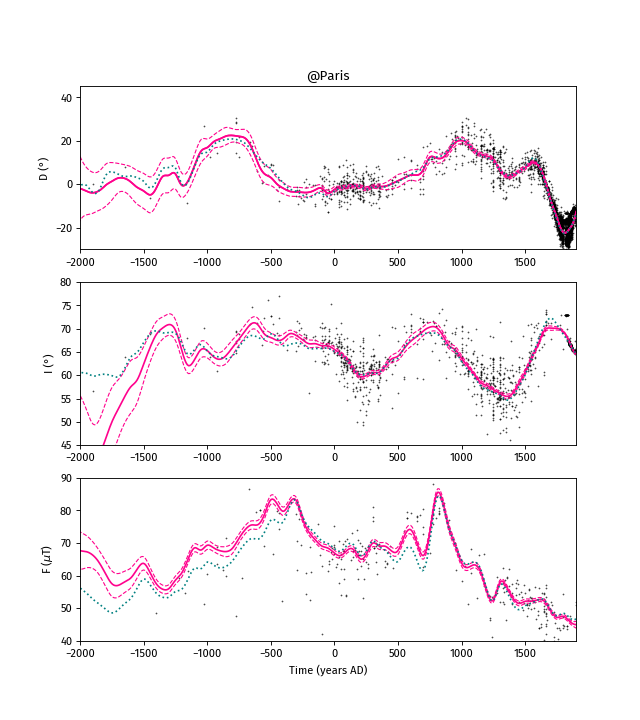

In [21]:
matplotlib.rcParams.update({'font.size': 10})

fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(8,9),
                                       gridspec_kw = {"height_ratios" : [1, 1, 1]})

common={"marker" : ".", "s" : 1, "alpha" : 0.8, "color" : "xkcd:black"}
sha_style = {"color" : "xkcd:dark red", "linestyle" : "--", "linewidth" : 2}
rscha_style = {"color" : "xkcd:light red", "alpha" : 0.005}

curve_color = "xkcd:light red"
curve_style = {"linewidth" : 1.5}
curve_style_2 = {"linewidth" : 1.5, "linestyle" : ":", "color" : "teal"}
curve_style_3 = {"linewidth" : 1, "linestyle" : "--"}

ax0.set_ylabel("D (°)")
ax1.set_ylabel("I (°)")
ax2.set_ylabel("F ($\mu $T)")
ax0.set_title("@{}".format(name_at))

cmap = pyplot.cm.viridis

ax0.scatter(model.tv[near], numpy.rad2deg(D_reloc)[near], **common)
#for cv in D_cur_boot.T:
#    ax0.plot(t_cur, numpy.rad2deg(cv), **curve_style, color="blue", alpha=0.1)
ax0.plot(t_cur, numpy.rad2deg(D_avg), **curve_style, color="xkcd:hot pink")
ax0.plot(t_cur, numpy.rad2deg(D_avg + D_std), **curve_style_3, color="xkcd:hot pink")
ax0.plot(t_cur, numpy.rad2deg(D_avg - D_std), **curve_style_3, color="xkcd:hot pink")
ax0.plot(t_cur, numpy.rad2deg(D_avg), **curve_style, color="xkcd:hot pink")
ax0.plot(t_cur, numpy.rad2deg(curves_zero[0]), **curve_style_2)
ax0.set_ybound(-30, 45)

ax1.scatter(model.tv[near], numpy.rad2deg(I_reloc)[near], **common)
#for cv in I_cur_boot.T:
#    ax1.plot(t_cur, numpy.rad2deg(cv), **curve_style, color="blue", alpha=0.1)
ax1.plot(t_cur, numpy.rad2deg(I_avg), **curve_style, color="xkcd:hot pink")
ax1.plot(t_cur, numpy.rad2deg(I_avg + I_std), **curve_style_3, color="xkcd:hot pink")
ax1.plot(t_cur, numpy.rad2deg(I_avg - I_std), **curve_style_3, color="xkcd:hot pink")
ax1.plot(t_cur, numpy.rad2deg(curves_zero[1]), **curve_style_2)
ax1.set_ybound(45, 80)

ax2.scatter(model.tv[near], F_reloc[near], **common)
#for cv in F_cur_boot.T:
#    ax2.plot(t_cur, cv, **curve_style, color="blue", alpha=0.1)
ax2.plot(t_cur, F_avg, **curve_style, color="xkcd:hot pink")
ax2.plot(t_cur, F_avg + F_std, **curve_style_3, color="xkcd:hot pink")
ax2.plot(t_cur, F_avg - F_std, **curve_style_3, color="xkcd:hot pink")
ax2.plot(t_cur, curves_zero[2], **curve_style_2)
ax2.set_ybound(40, 90)
ax2.set_xlabel("Time (years AD)")
    
for ax in (ax0, ax1, ax2):
    ax.set_xbound(-2000, 1900)
    ax.set_facecolor("white")

fig.show()

In [22]:
# residuos

g_avg = numpy.average(gs, axis=0)

ind = (model.tv > -2000)
D_rs, I_rs, F_rs = model.synth_data(model.tv[ind], rs[ind], model.theta_geo[ind], model.phi_geo[ind], g)
D_res = trig.mindiff(D_rs, model.D_o[ind])
I_res = trig.mindiff(I_rs, model.I_o[ind])
F_res = F_rs - model.F_o[ind]


________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.261894, ...,  0.239397]), array([ 0.693138, ...,  2.278571]), 0.4537856055185257, array([ 20.234213, ..., -11.563298]), array([ 22.020365, ...,  19.988024]), array([ 30.493598, ...,  46.37134 ]), 50.538353159220478)
______________________________________rscha_condition_matrix_dif - 30.9s, 0.5min


<IPython.core.display.Javascript object>


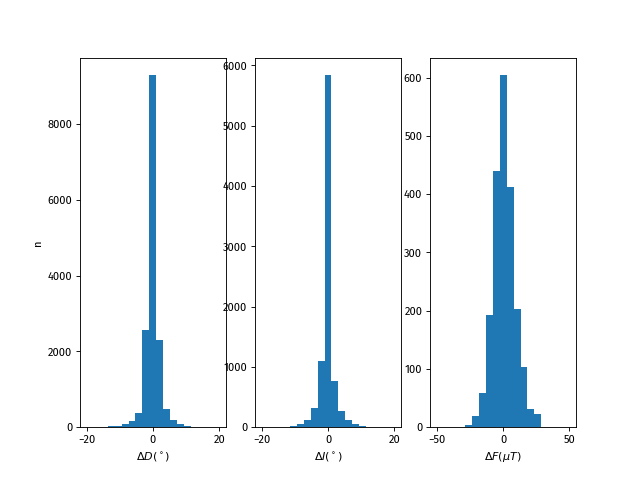

In [23]:
fig, (ax0, ax1, ax2) = pyplot.subplots(1, 3, figsize=(8,6))

D_range = numpy.linspace(-20, 20, 20)
I_range = numpy.linspace(-20, 20, 20)
F_range = numpy.linspace(-50, 50, 20)

ax0.hist(numpy.rad2deg(D_res[~model.nan_D[ind]]), bins=D_range)
ax1.hist(numpy.rad2deg(I_res[~model.nan_I[ind]]), bins=I_range)
ax2.hist(F_res[~model.nan_F[ind]], bins=F_range)

ax0.set_xlabel("$\Delta D ({}^\circ)$")
ax1.set_xlabel("$\Delta I ({}^\circ)$")
ax2.set_xlabel("$\Delta F (\mu T)$")
ax0.set_ylabel("n")

fig.savefig(savepath+"/residuals.png")
fig.show()

In [24]:
#draw maps (1)

import coords
import scha
import fibonacci_sphere
from mpl_toolkits.basemap import Basemap
import field_plots

times_long = numpy.arange(-2000, 1950, 50)
#times_long = numpy.arange(-1000, 2200, 500)

theta_in, phi_in = fibonacci_sphere.grid(n=8000)
in_cap = trig.angulardist(theta_in, phi_in, theta_c, phi_c) < model.theta_0p
theta_in = theta_in[in_cap]
phi_in = phi_in[in_cap]

rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)

lon_c, lat_c = numpy.rad2deg((phi_c, numpy.pi/2 - theta_c))
base_cap = Basemap(projection="npaeqd", lon_0 = 0, boundinglat=90-numpy.rad2deg(model.theta_0p))
base_world = Basemap(projection="aeqd", lon_0 = lon_c, lat_0 = lat_c, lat_ts=45.0,
                    width=base_cap.xmax, height=base_cap.ymax, resolution="l")

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ..., -4]), array([-28, ...,  17]), array([50, ..., 49]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


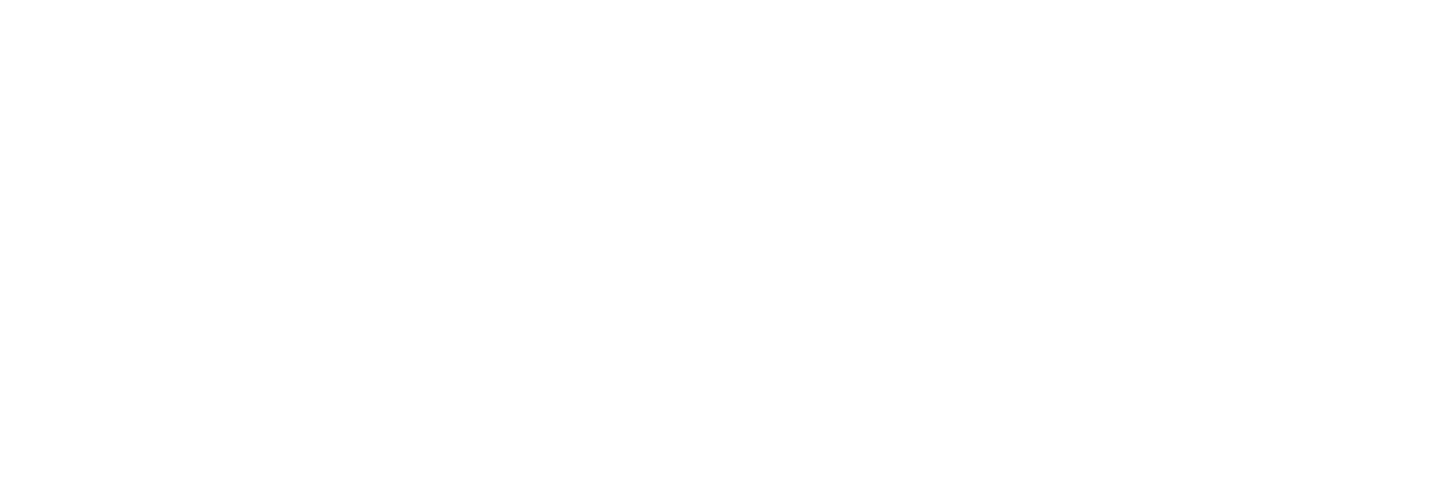

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ..., -4]), array([-27, ...,  16]), array([48, ..., 46]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


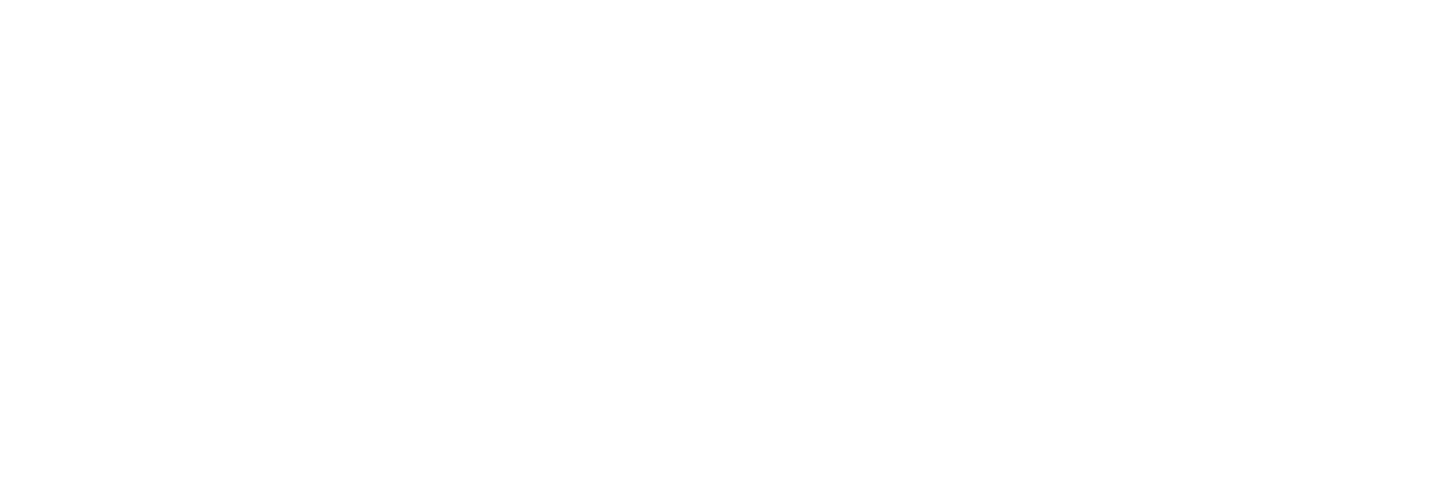

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-2, ..., -4]), array([-26, ...,  18]), array([47, ..., 42]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.7s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


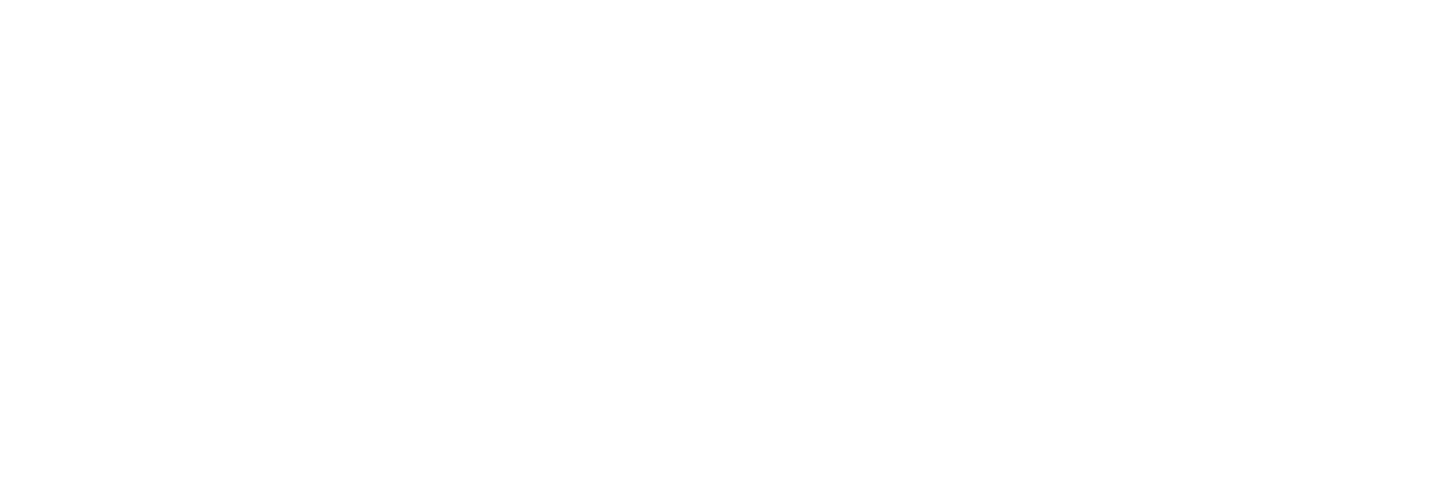

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ..., -3]), array([-25, ...,  18]), array([45, ..., 43]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.7s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


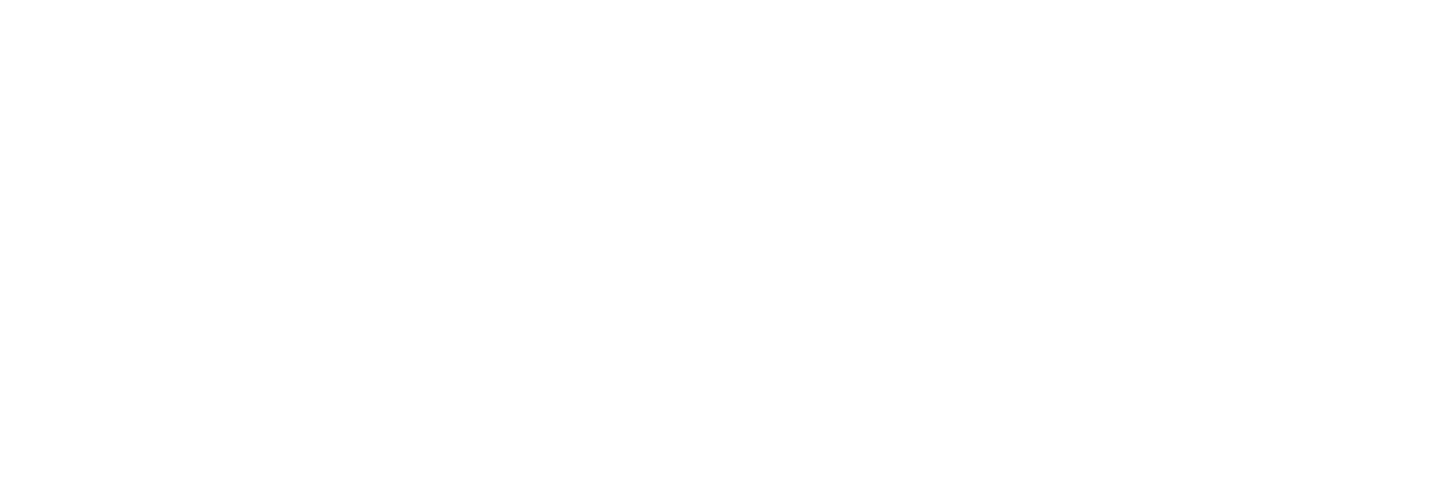

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -4]), array([-24, ...,  17]), array([41, ..., 46]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


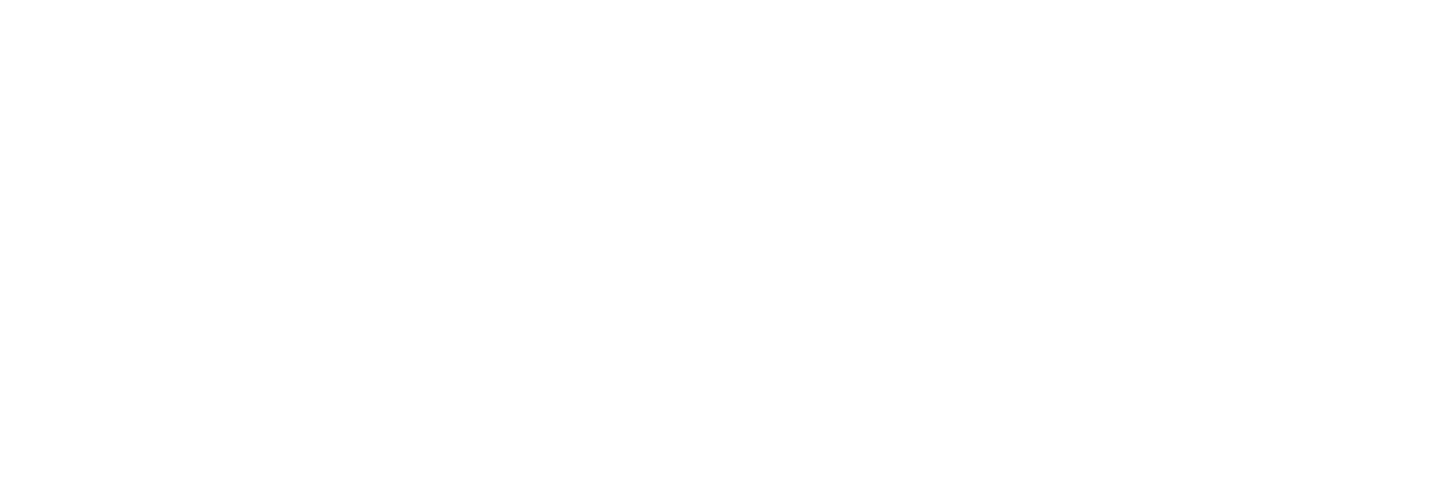

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -5]), array([-24, ...,  18]), array([39, ..., 46]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.7s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


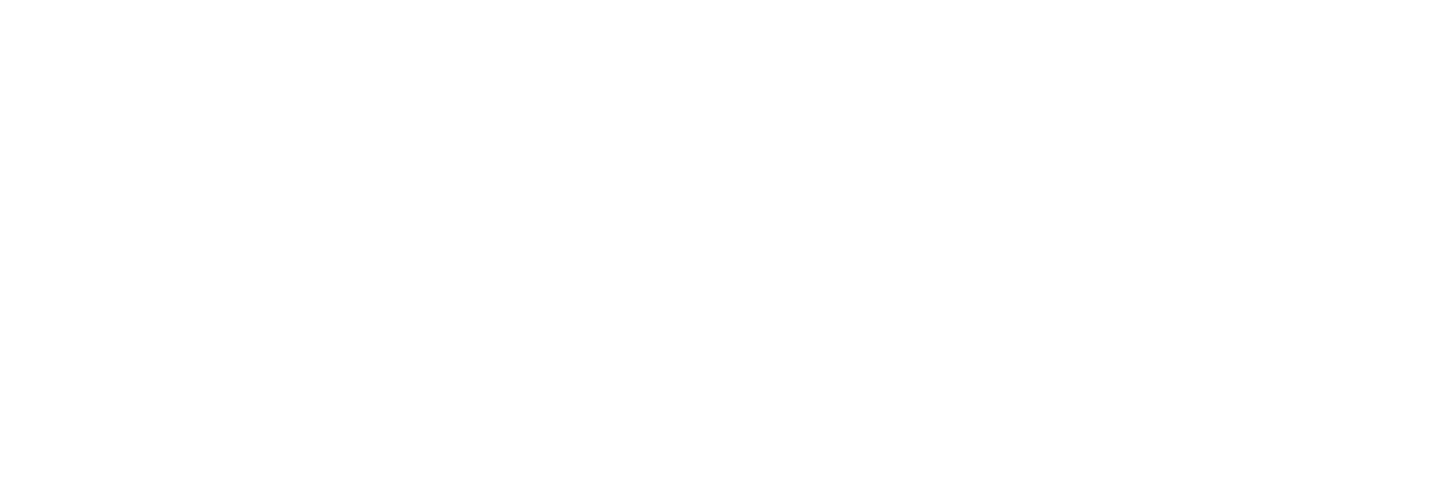

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -5]), array([-25, ...,  19]), array([40, ..., 47]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


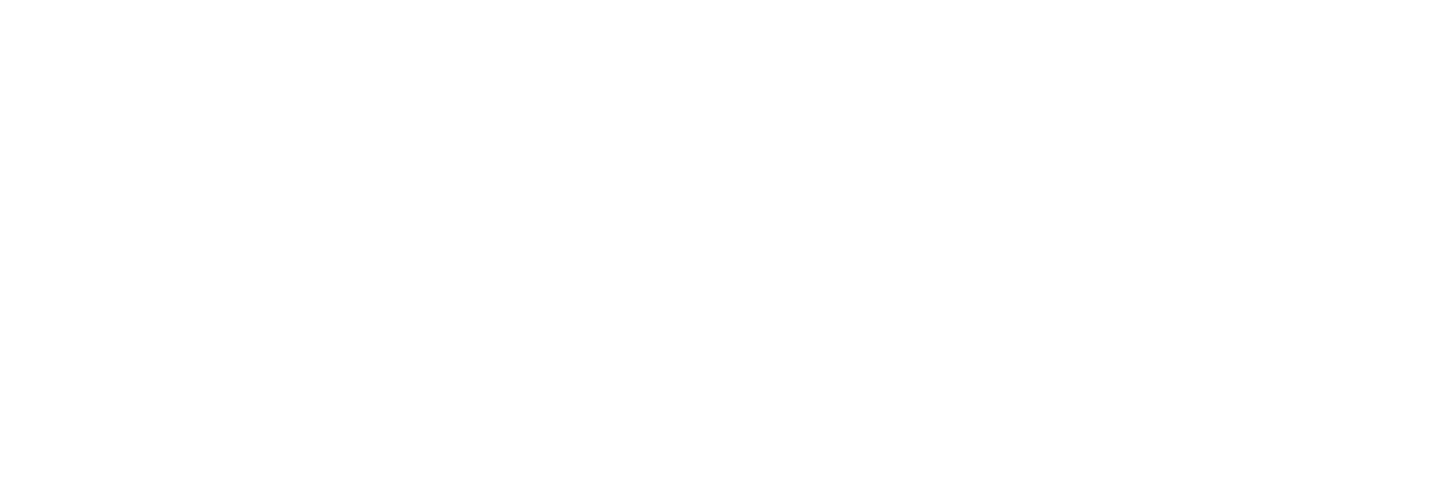

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -4]), array([-25, ...,  20]), array([43, ..., 47]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


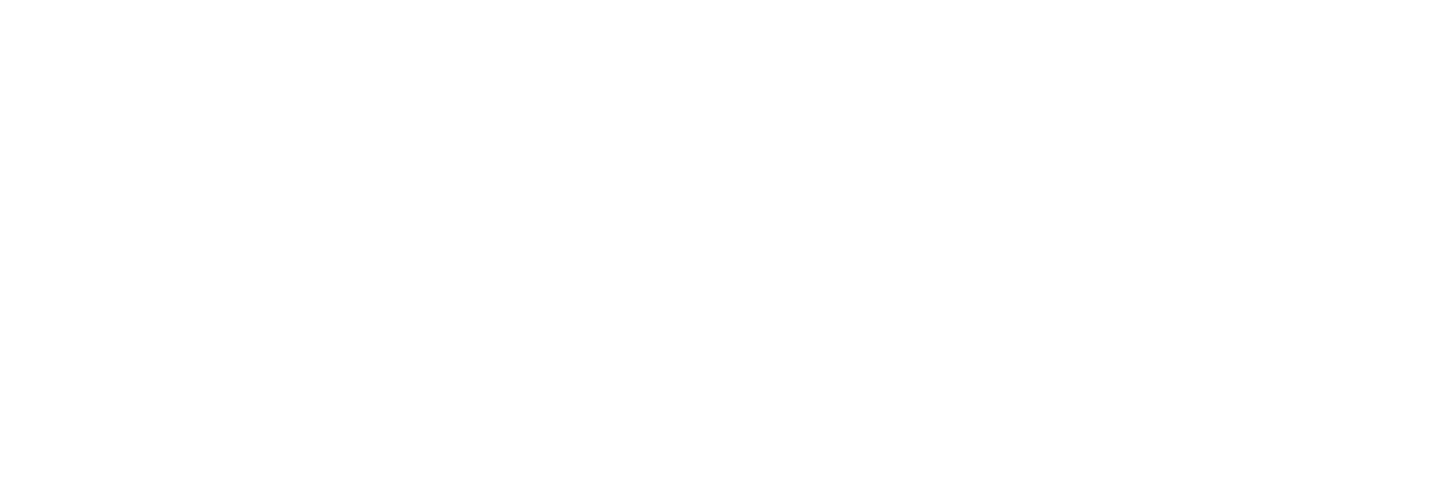

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -2]), array([-23, ...,  19]), array([45, ..., 48]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


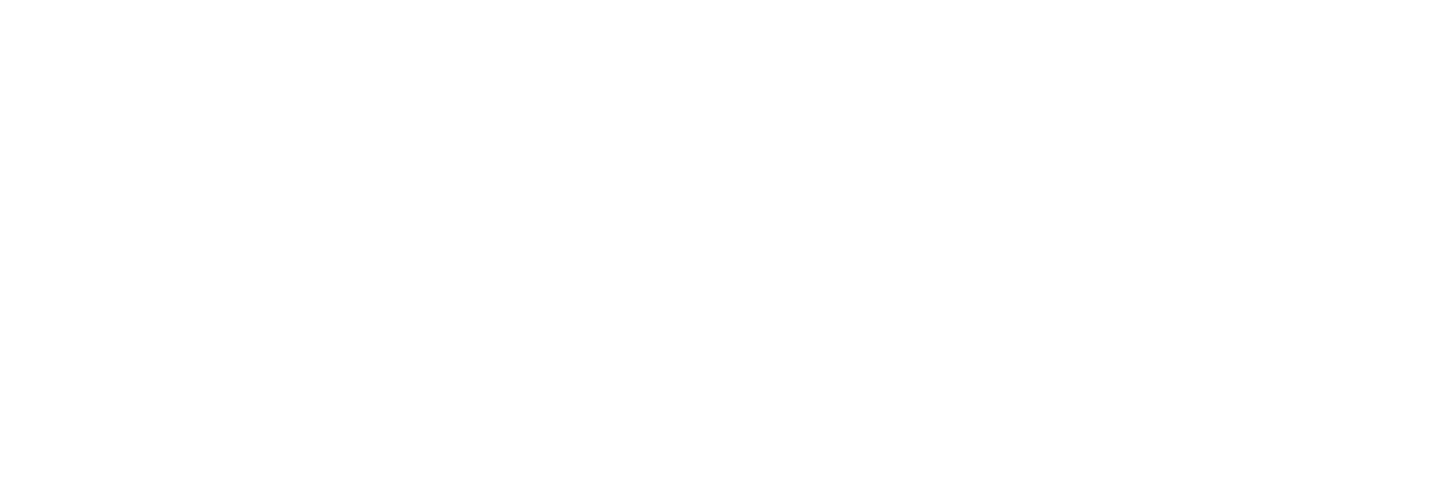

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -2]), array([-24, ...,  20]), array([49, ..., 51]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


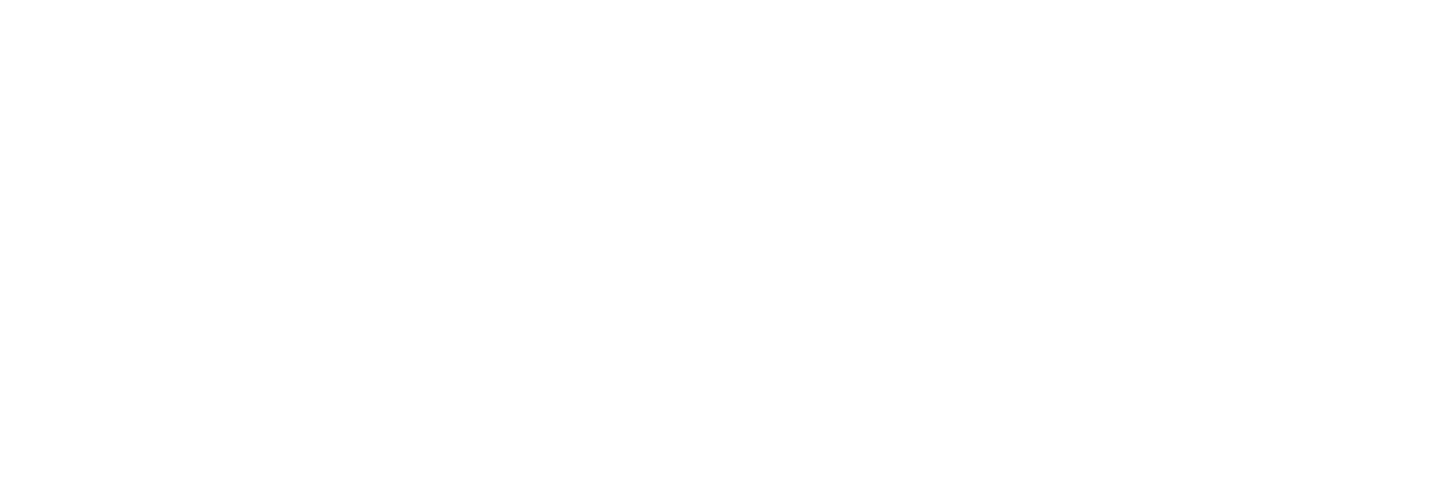

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -1]), array([-22, ...,  19]), array([53, ..., 54]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


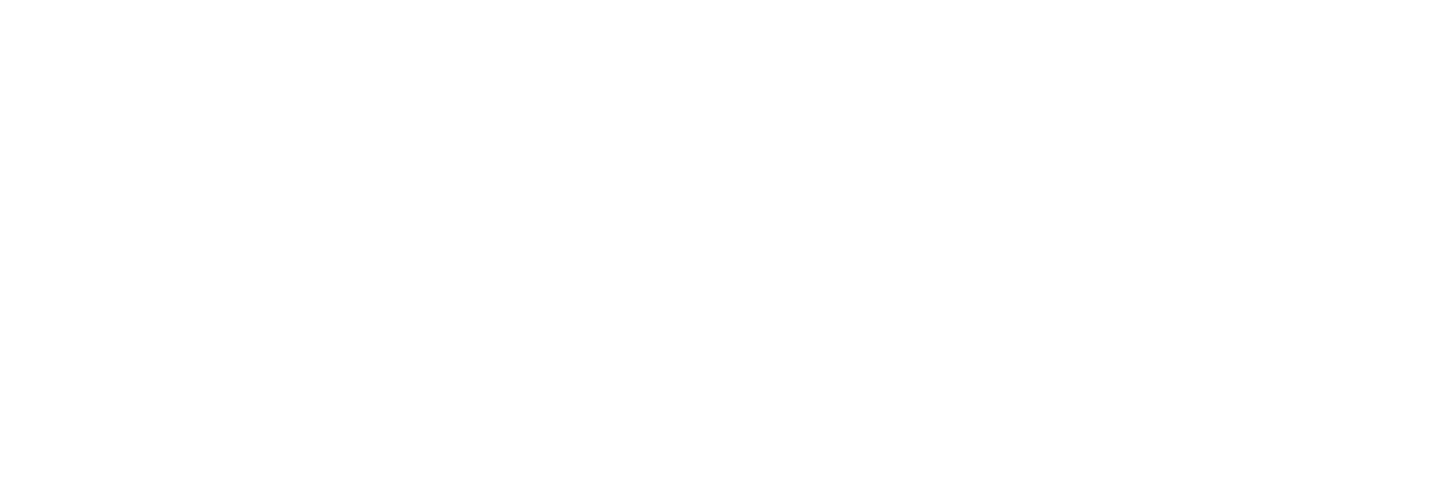

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ...,  0]), array([-20, ...,  18]), array([52, ..., 51]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


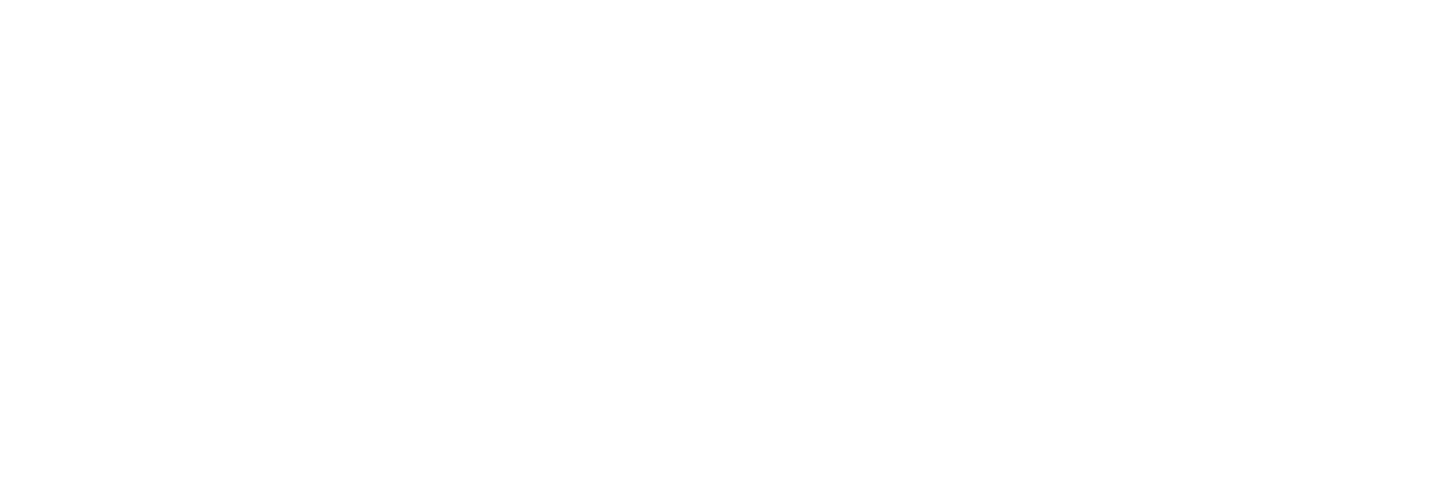

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 0]), array([-19, ...,  15]), array([50, ..., 51]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


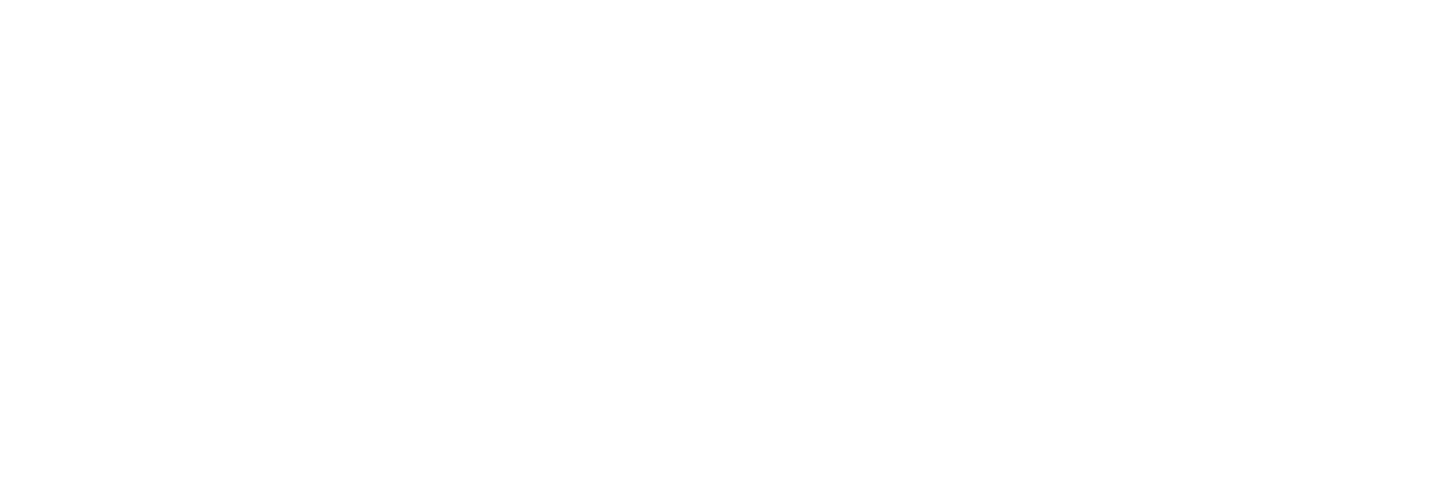

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -1]), array([-18, ...,  13]), array([48, ..., 54]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


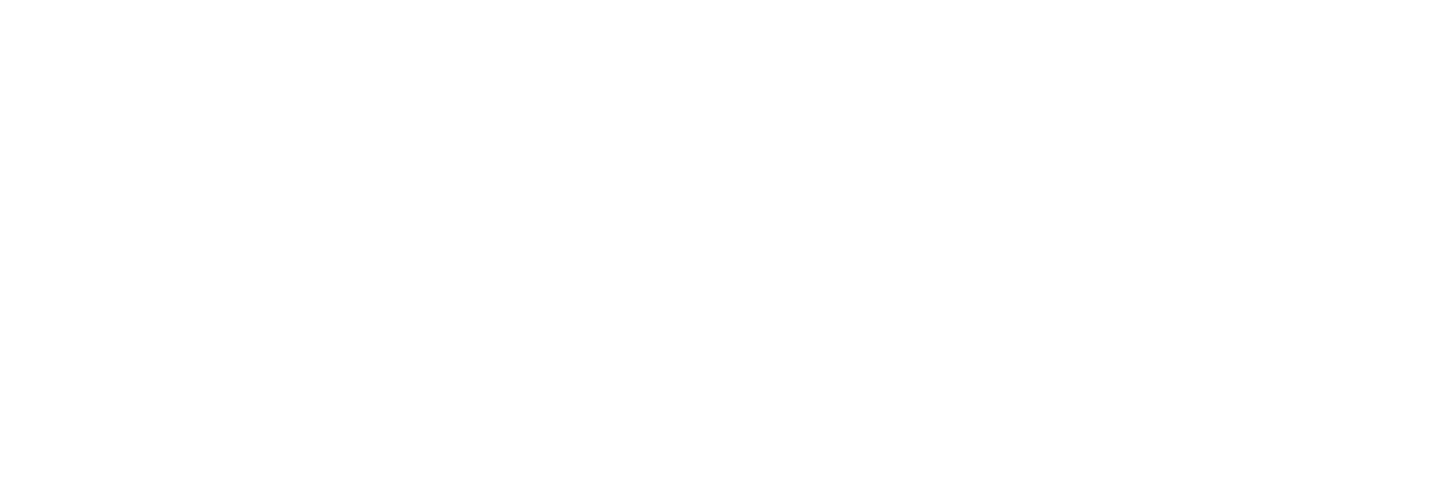

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -1]), array([-18, ...,  14]), array([48, ..., 55]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


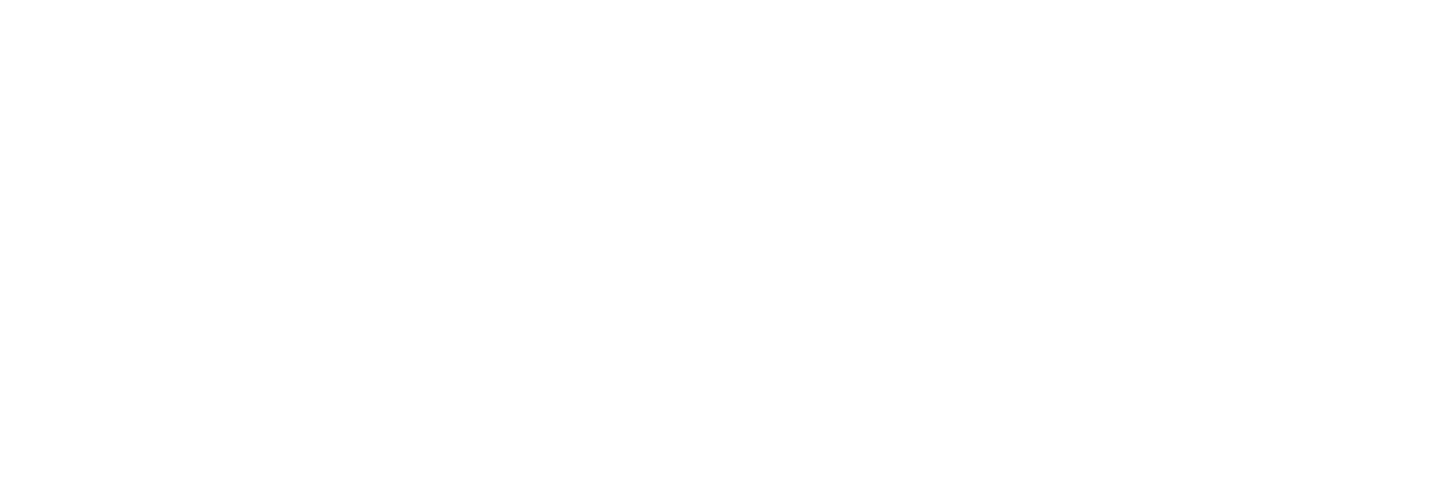

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -2]), array([-19, ...,  15]), array([49, ..., 57]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


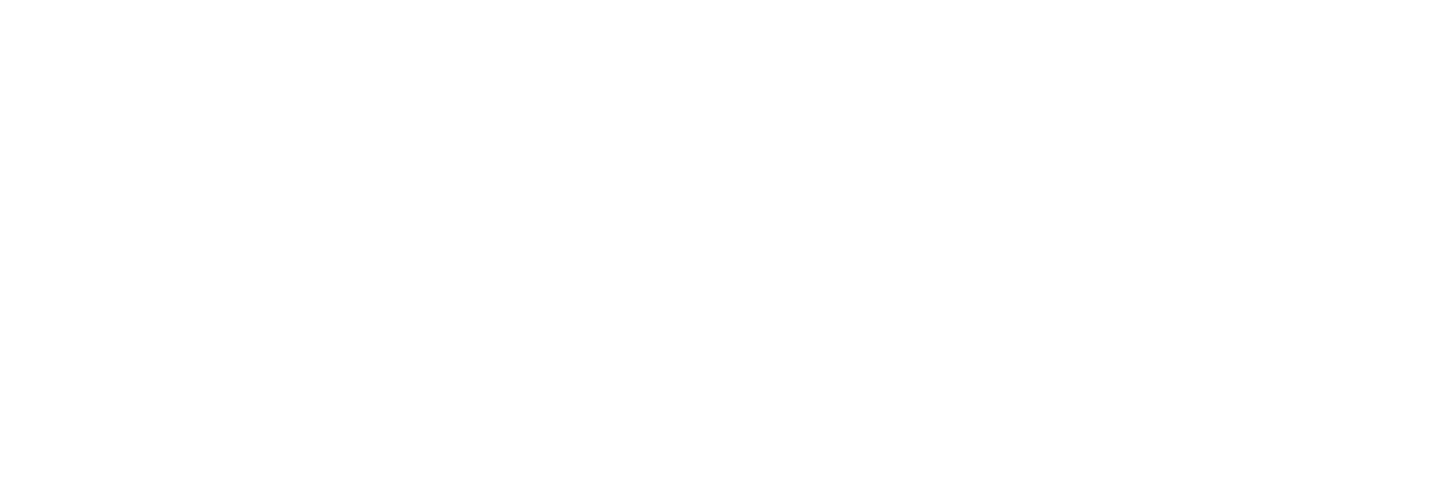

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-2, ..., -2]), array([-21, ...,  19]), array([51, ..., 55]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


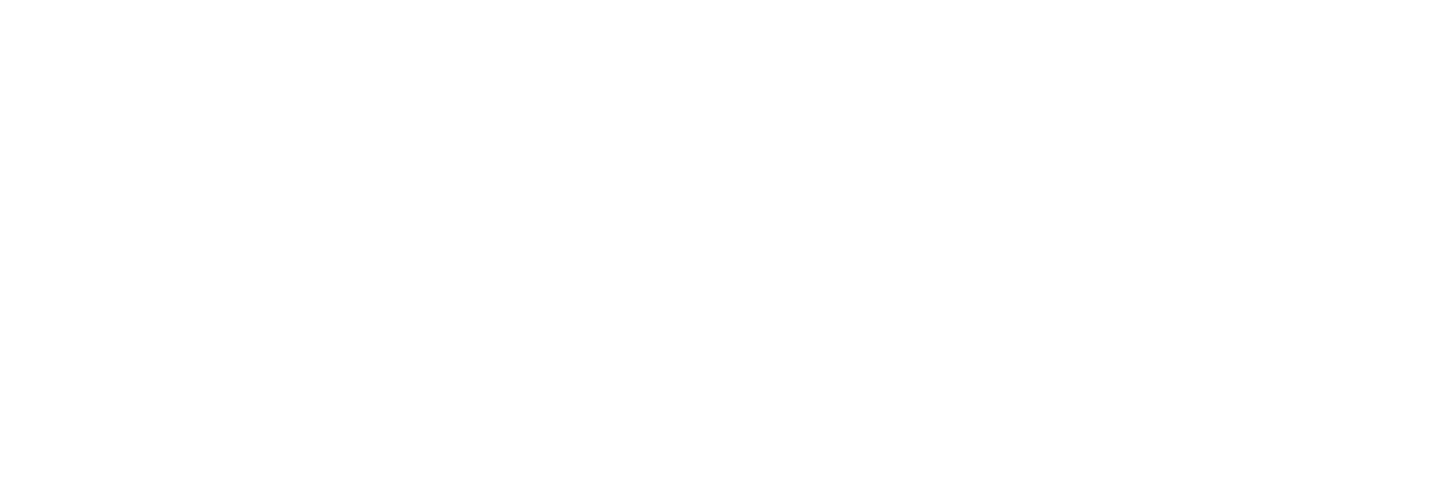

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-2, ..., -3]), array([-24, ...,  23]), array([52, ..., 58]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


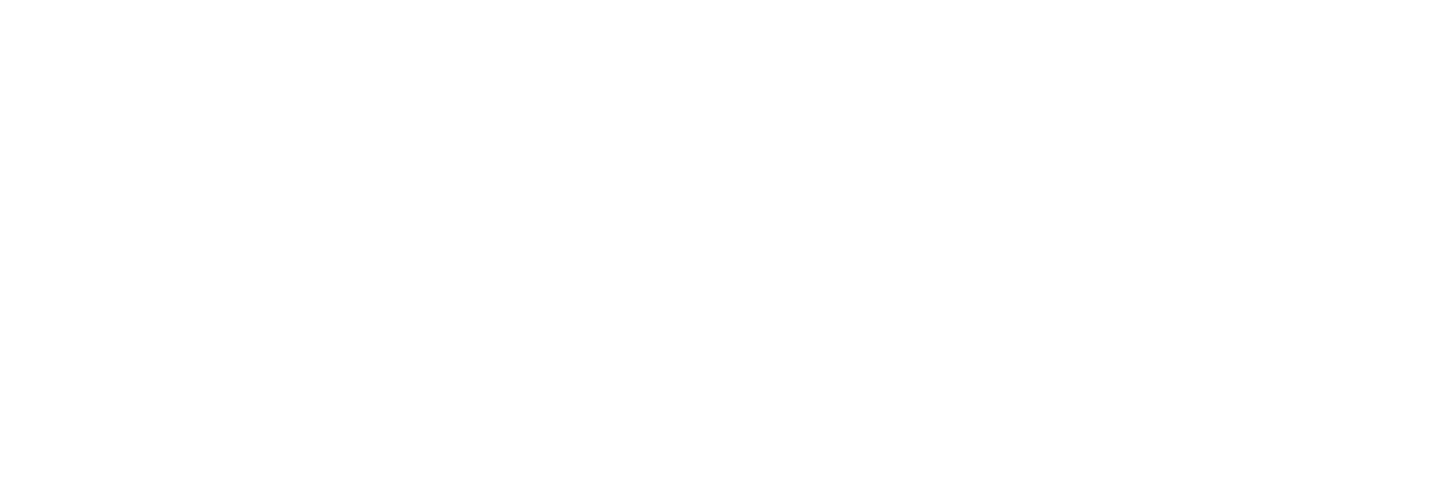

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -3]), array([-26, ...,  24]), array([53, ..., 64]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


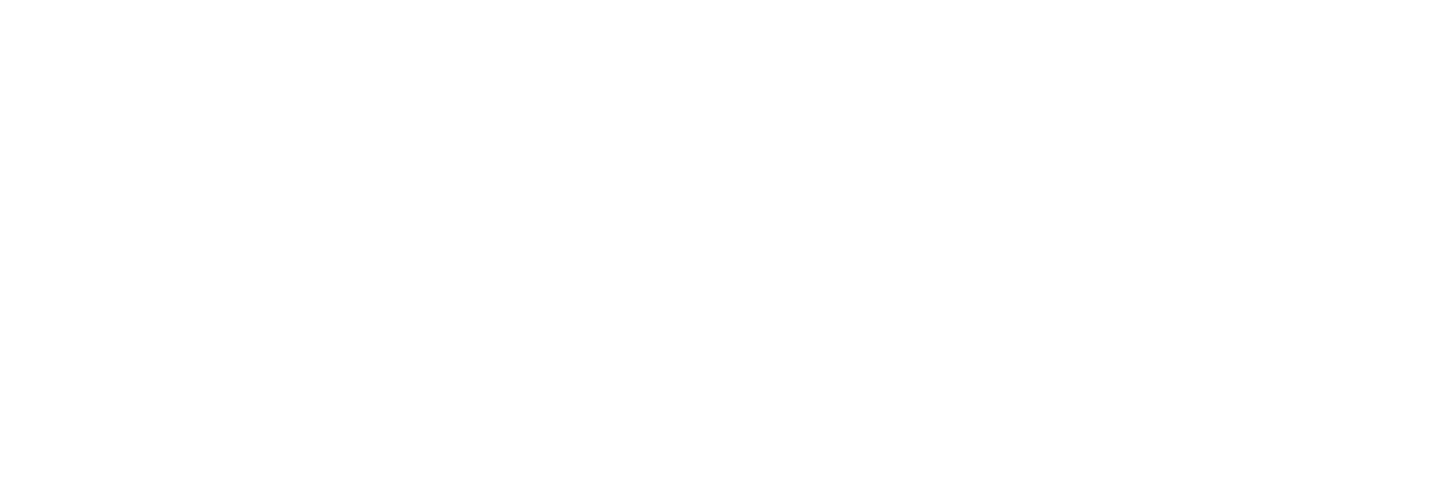

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 4, ..., -3]), array([-24, ...,  23]), array([52, ..., 66]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


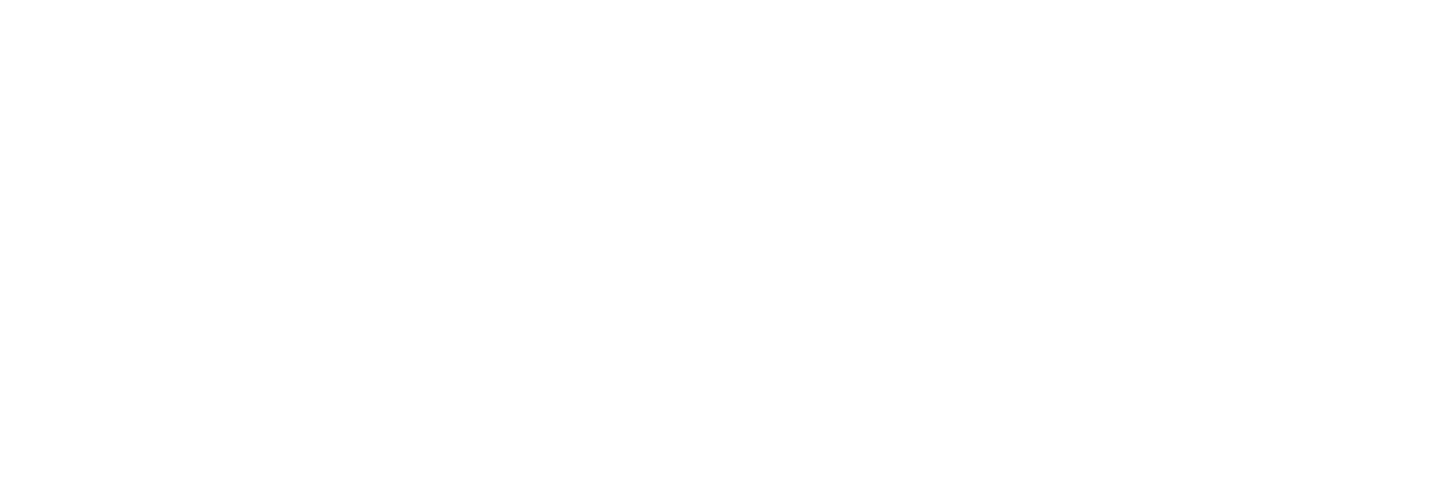

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 6, ..., -3]), array([-26, ...,  23]), array([53, ..., 70]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


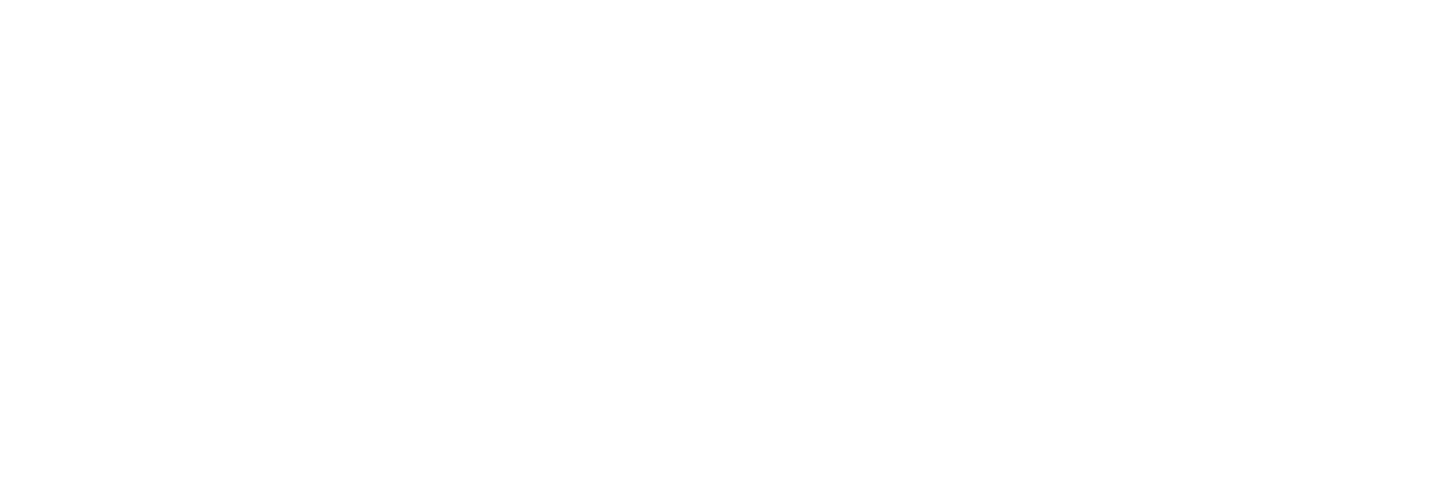

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 6, ..., -3]), array([-27, ...,  21]), array([51, ..., 73]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


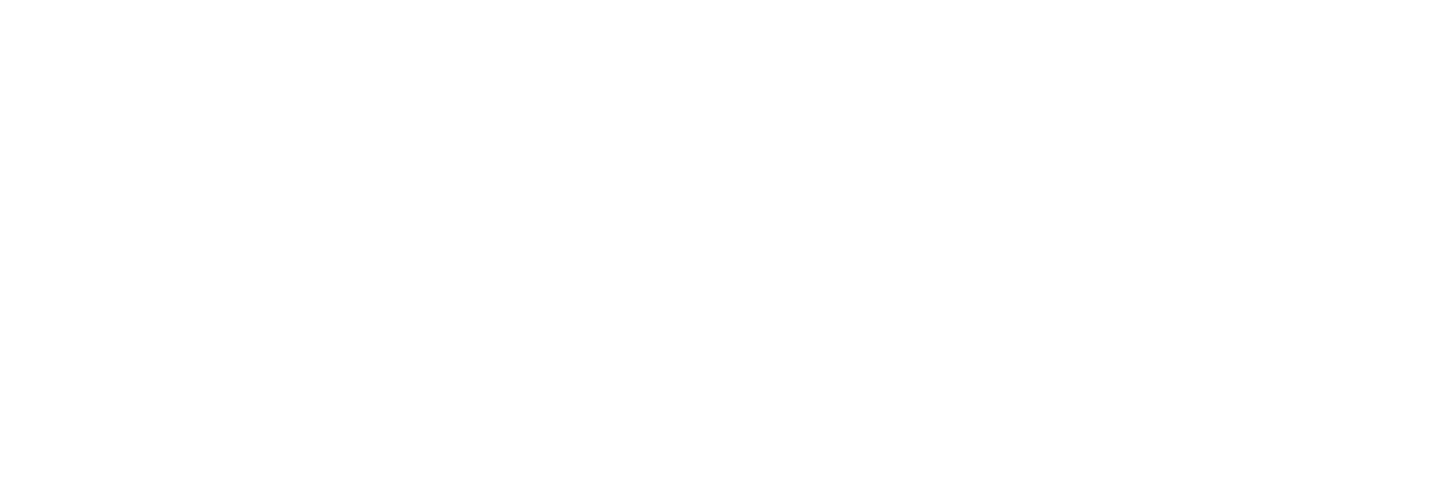

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 6, ..., -3]), array([-27, ...,  20]), array([50, ..., 75]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


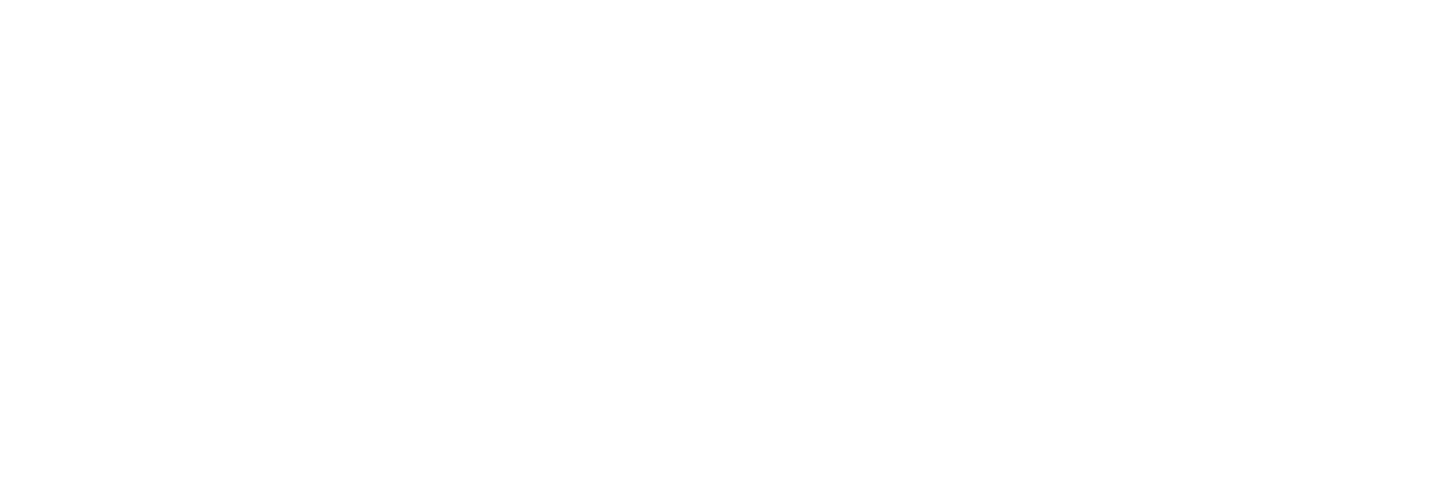

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 7, ..., -2]), array([-27, ...,  20]), array([49, ..., 78]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


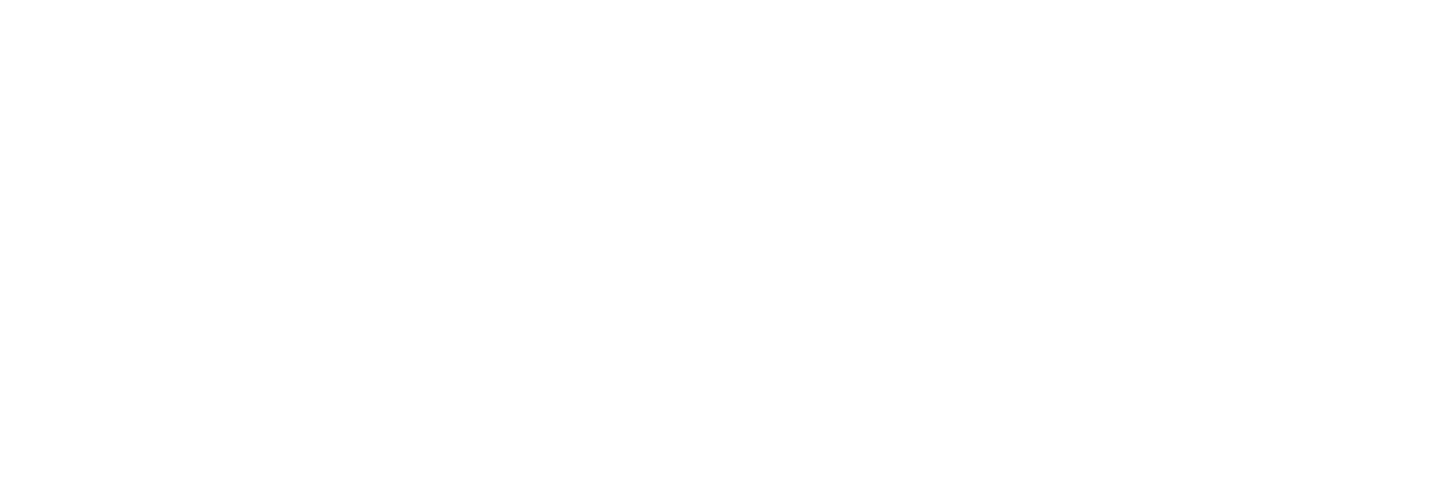

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([7, ..., 0]), array([-28, ...,  21]), array([51, ..., 81]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


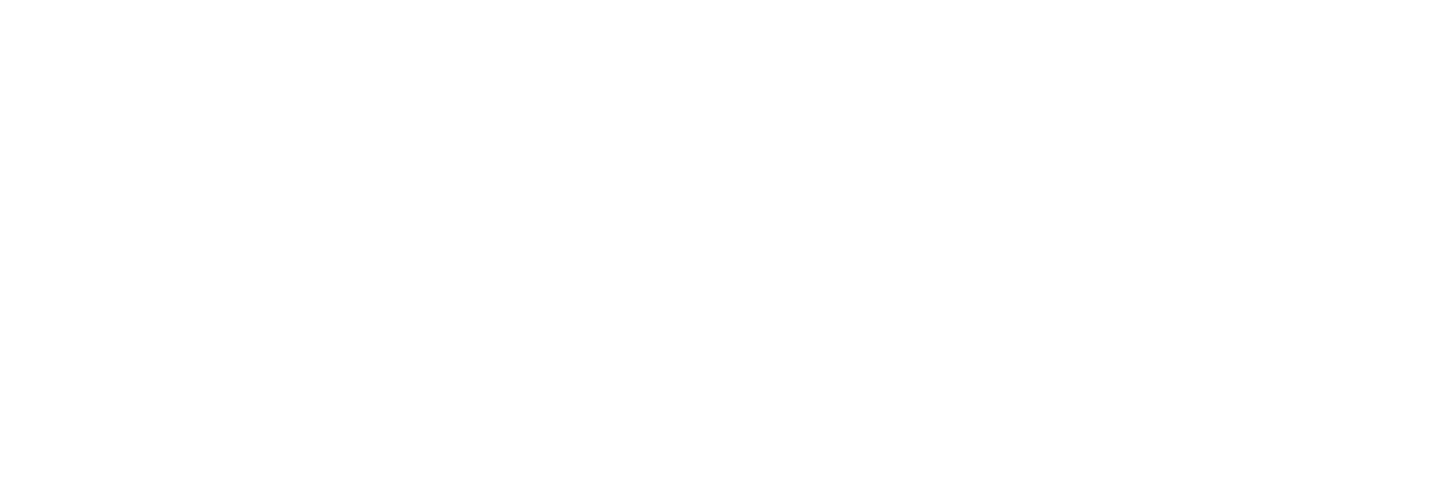

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([7, ..., 2]), array([-27, ...,  20]), array([55, ..., 83]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


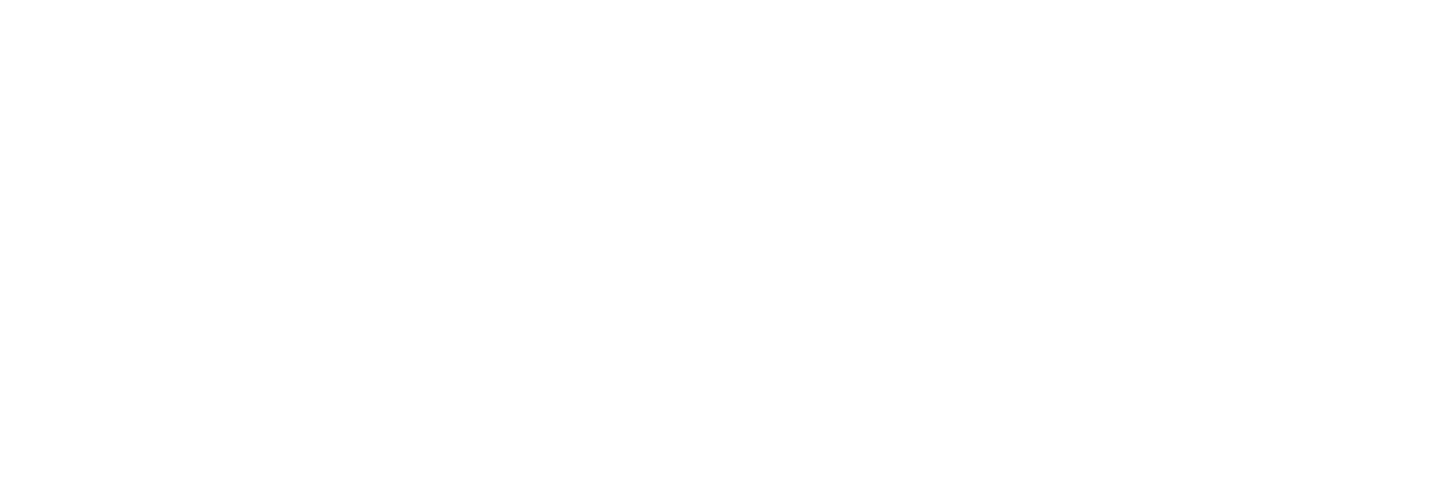

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([6, ..., 2]), array([-27, ...,  19]), array([60, ..., 84]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


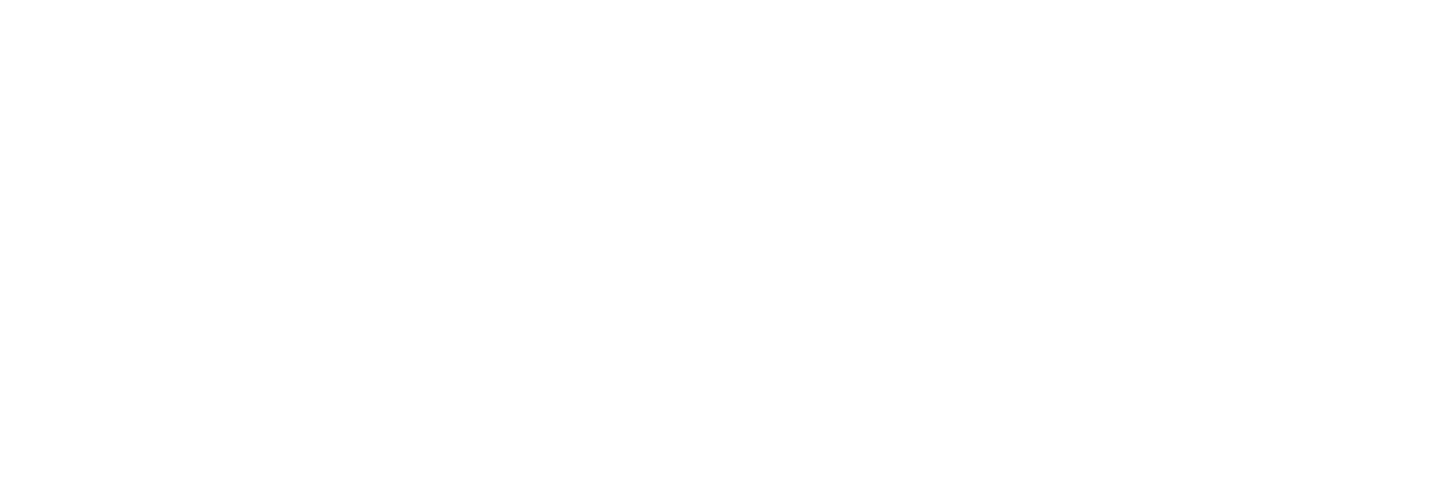

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([5, ..., 2]), array([-27, ...,  20]), array([64, ..., 83]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


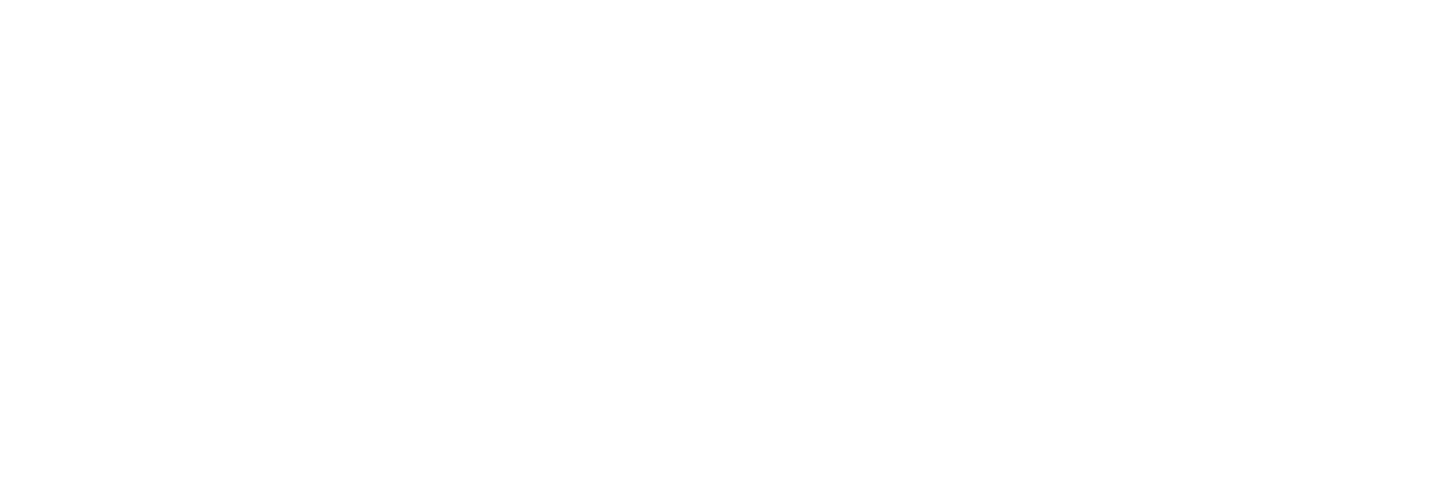

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([3, ..., 3]), array([-27, ...,  21]), array([64, ..., 82]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


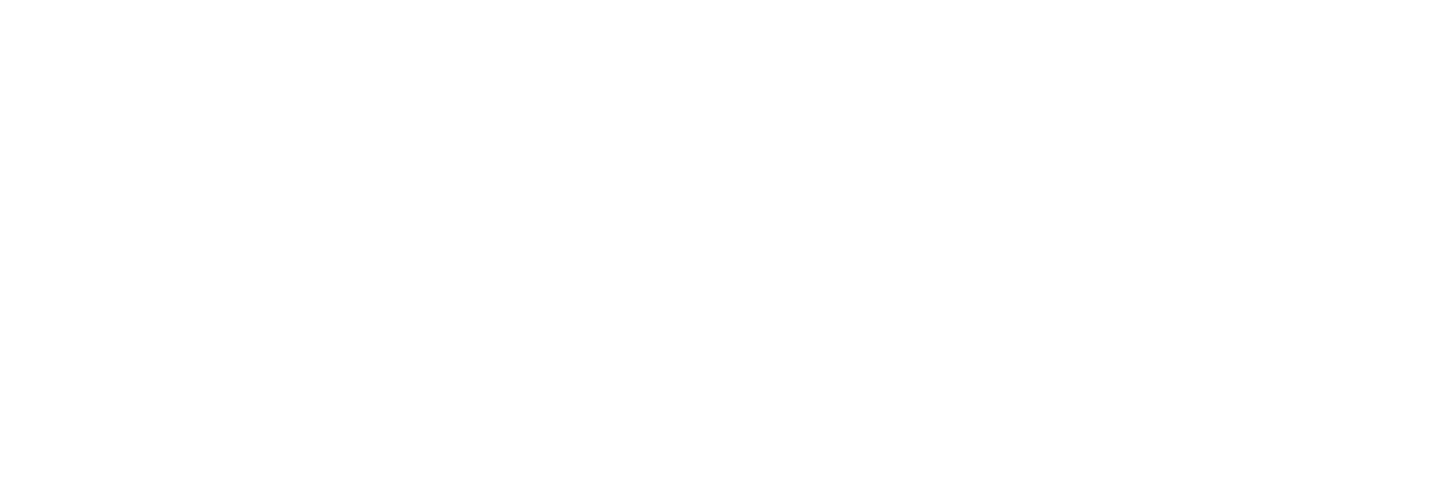

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([3, ..., 3]), array([-28, ...,  25]), array([65, ..., 81]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


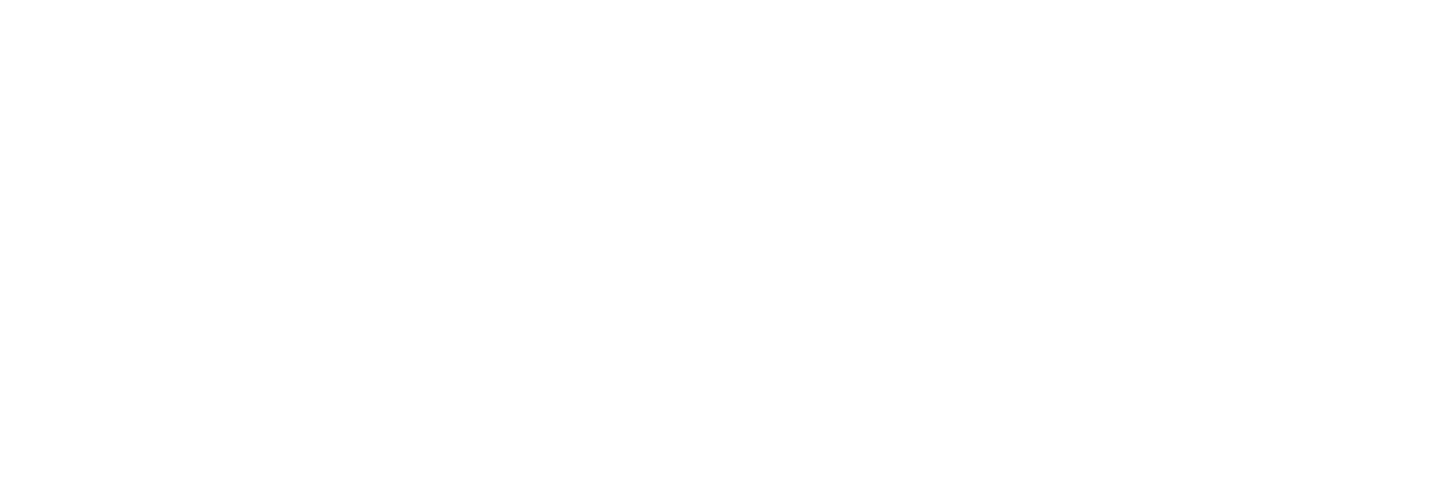

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([3, ..., 2]), array([-28, ...,  28]), array([69, ..., 82]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


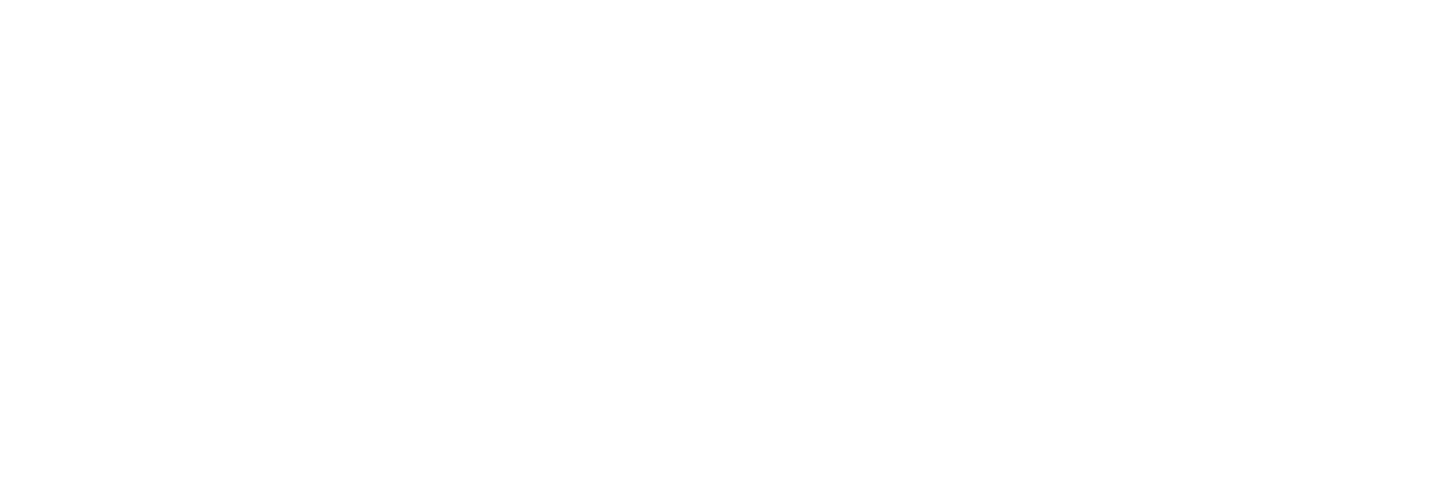

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([2, ..., 3]), array([-29, ...,  29]), array([69, ..., 80]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


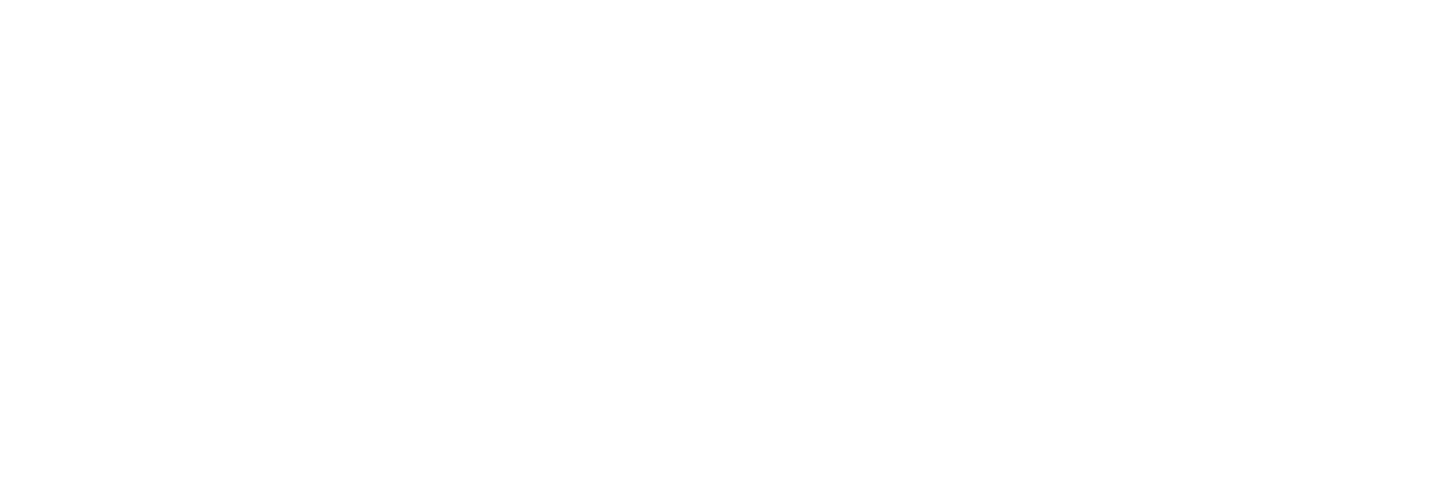

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 4]), array([-30, ...,  30]), array([69, ..., 76]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


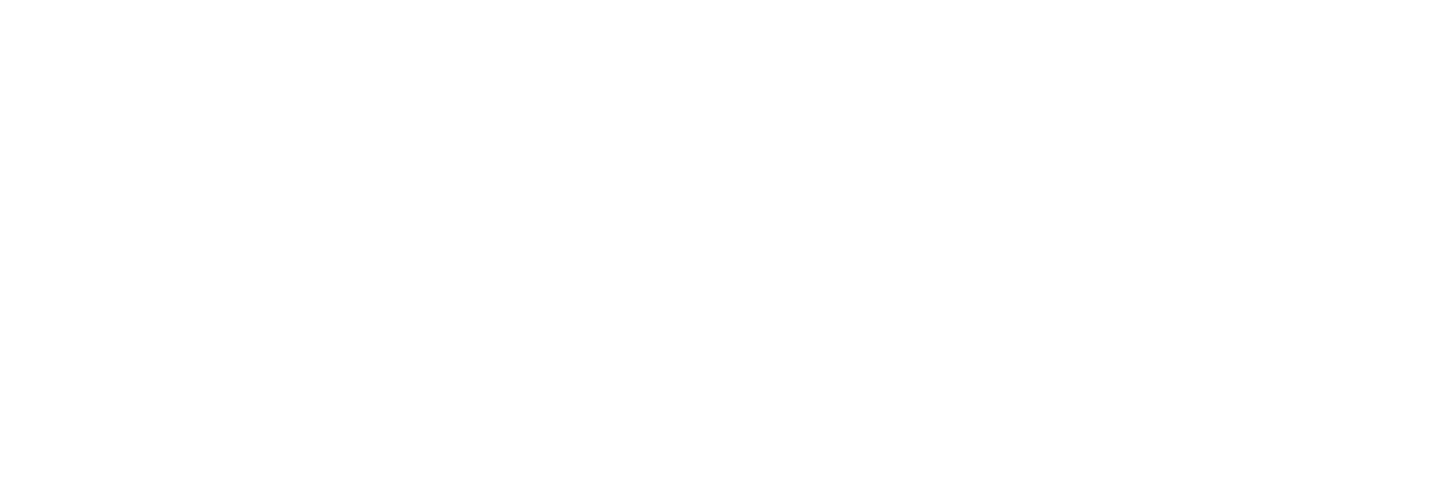

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 6]), array([-31, ...,  32]), array([73, ..., 76]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


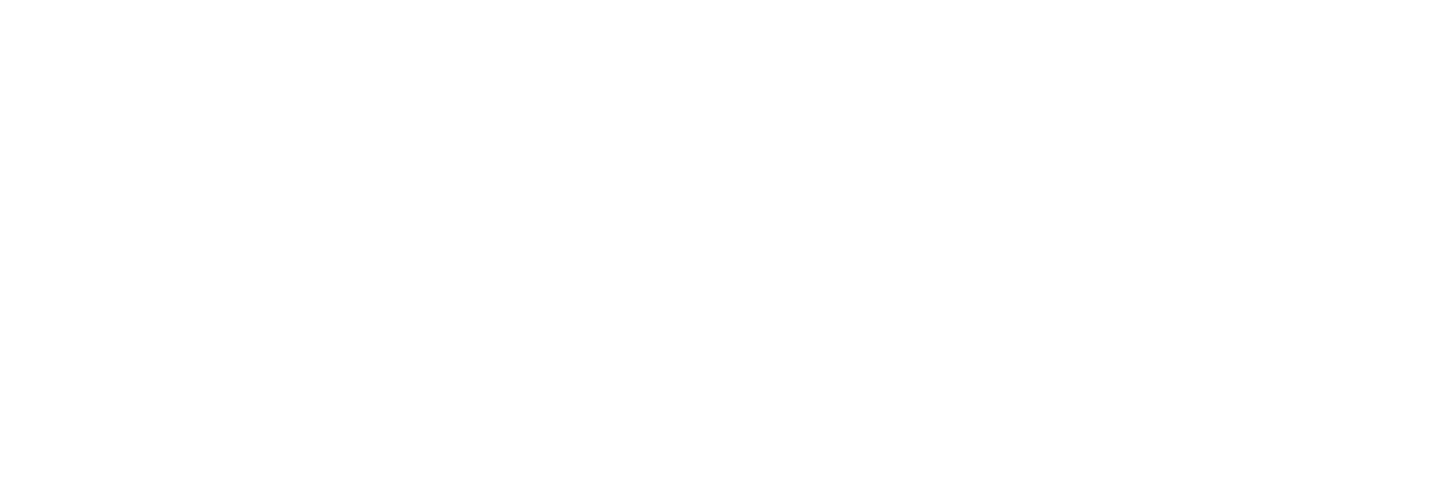

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 8]), array([-32, ...,  33]), array([75, ..., 73]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.7s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


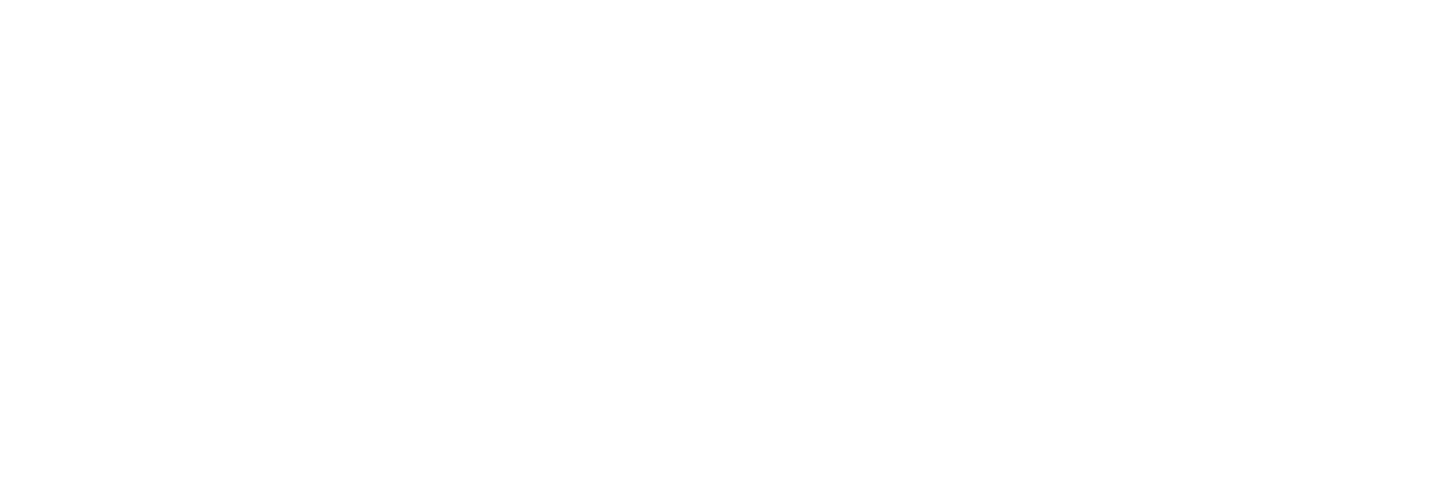

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ...,  6]), array([-30, ...,  31]), array([72, ..., 69]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.7s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


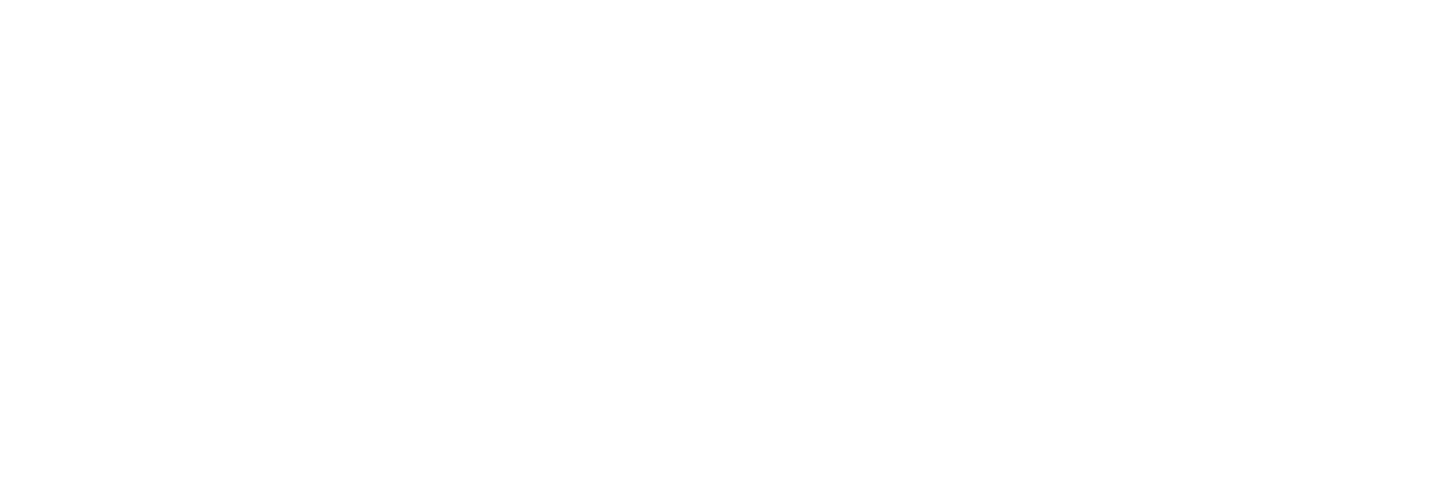

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-2, ...,  5]), array([-29, ...,  31]), array([70, ..., 66]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


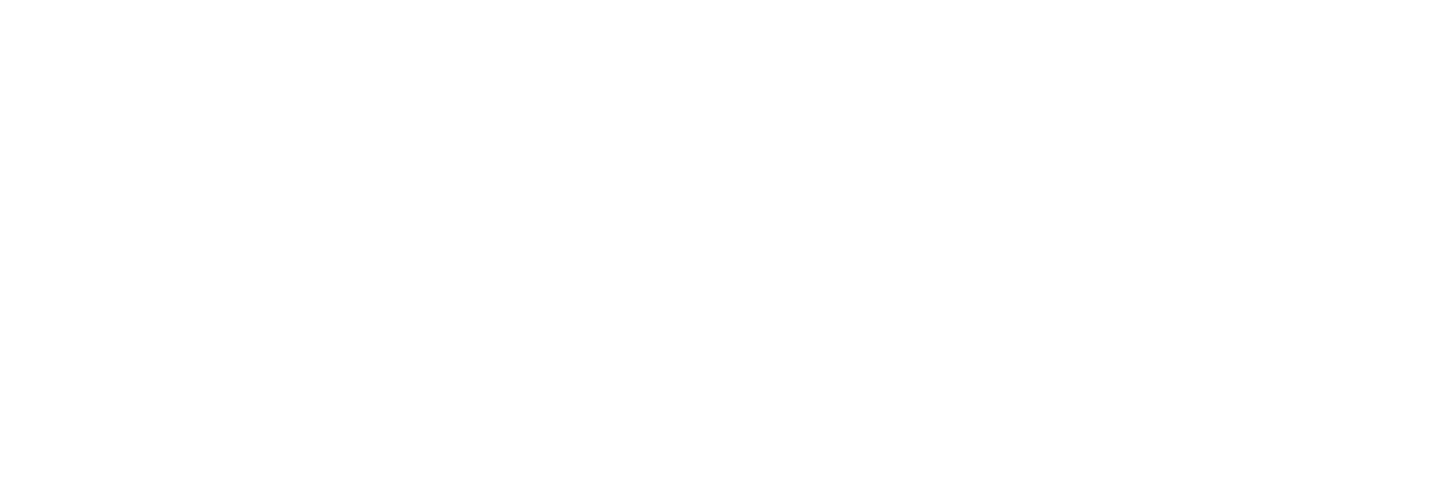

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ...,  5]), array([-29, ...,  28]), array([69, ..., 66]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


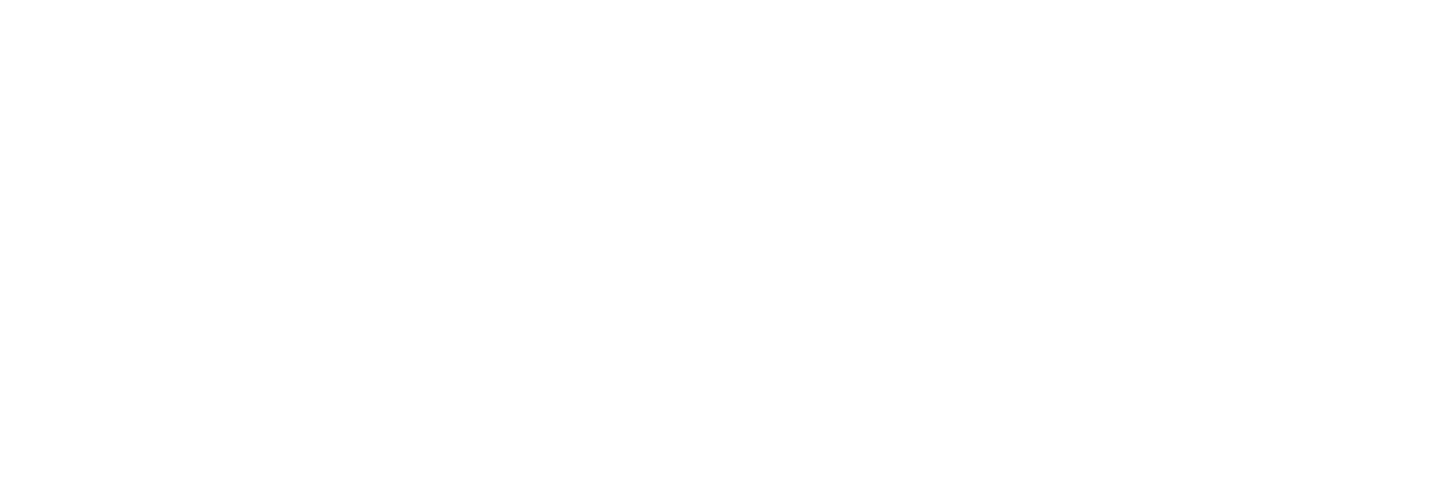

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-2, ...,  4]), array([-28, ...,  27]), array([66, ..., 64]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


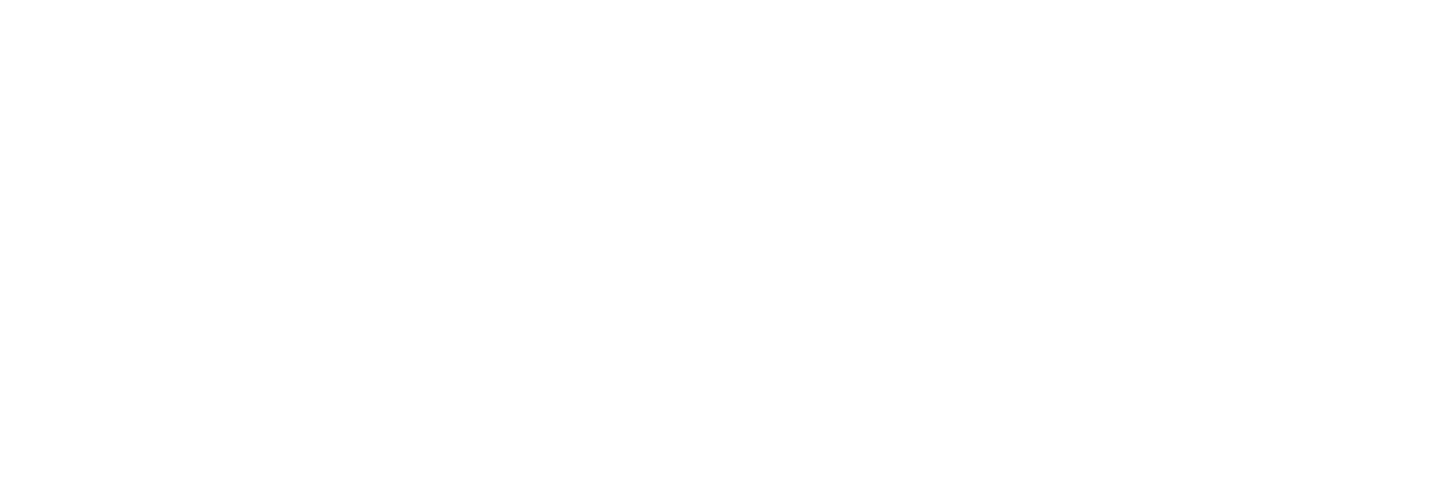

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-2, ...,  1]), array([-27, ...,  27]), array([66, ..., 62]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


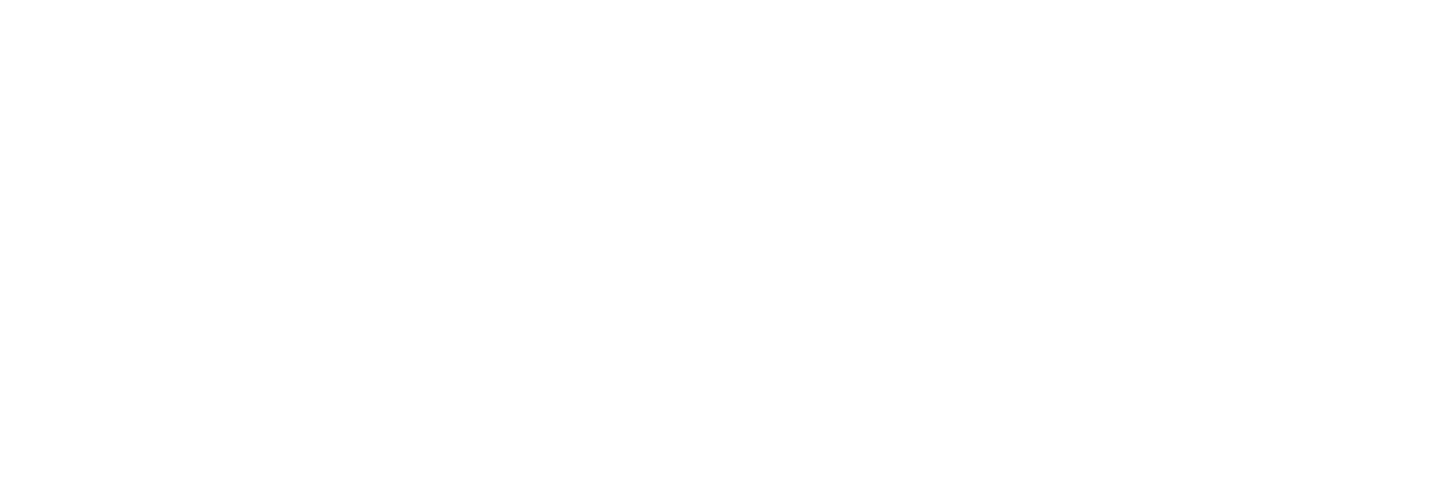

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 0]), array([-27, ...,  27]), array([62, ..., 61]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


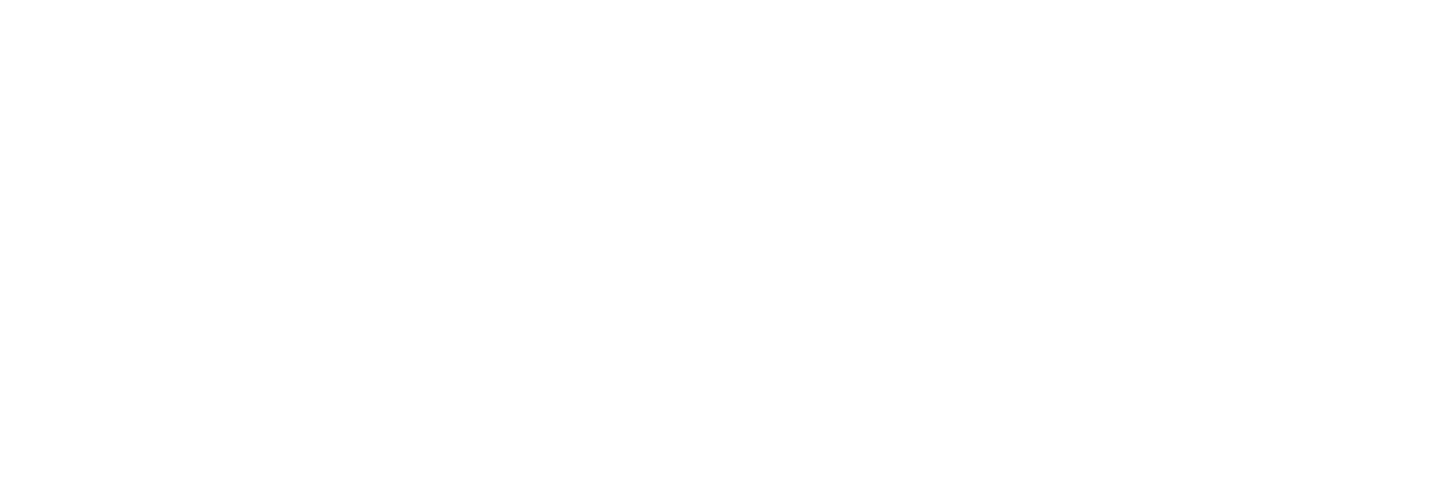

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 0]), array([-27, ...,  28]), array([60, ..., 60]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


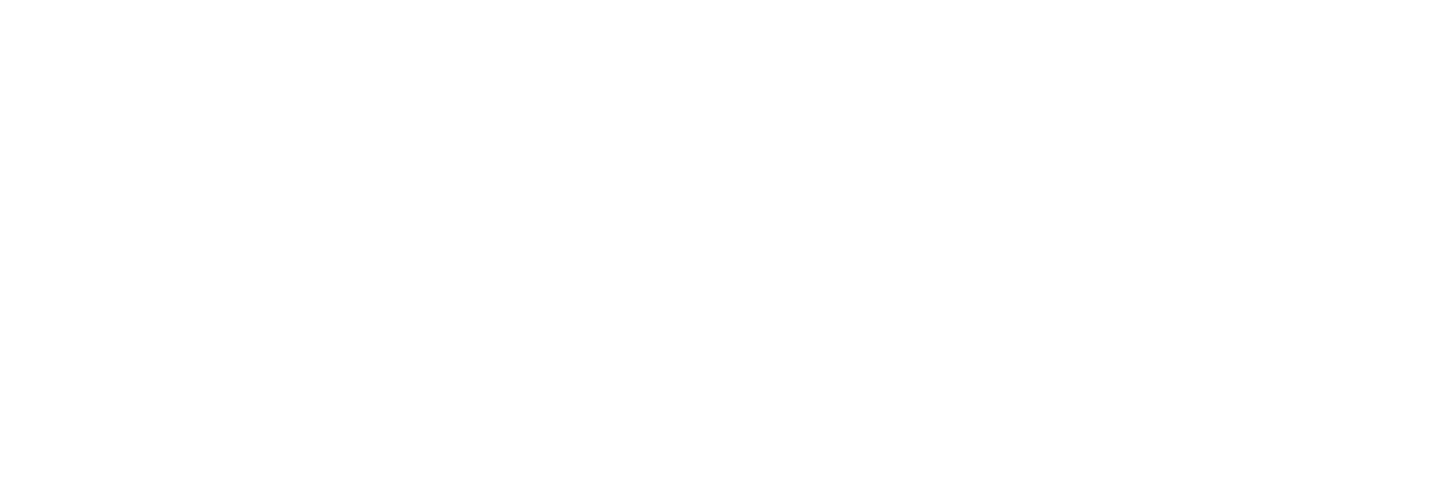

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 0]), array([-29, ...,  30]), array([61, ..., 62]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.7s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


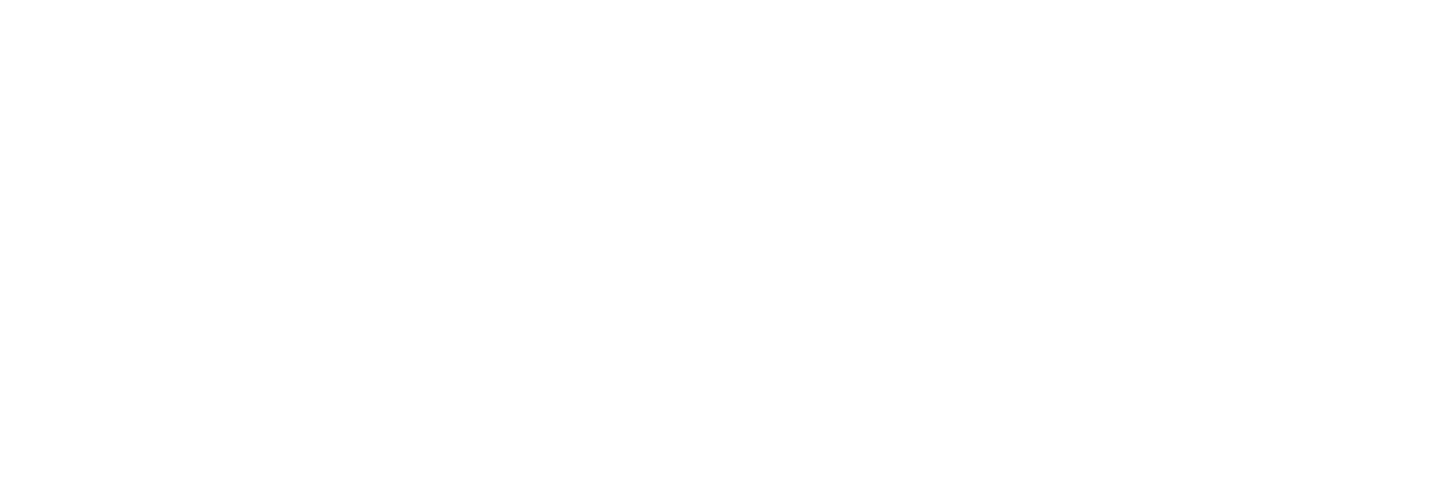

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ..., -1]), array([-31, ...,  31]), array([60, ..., 61]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


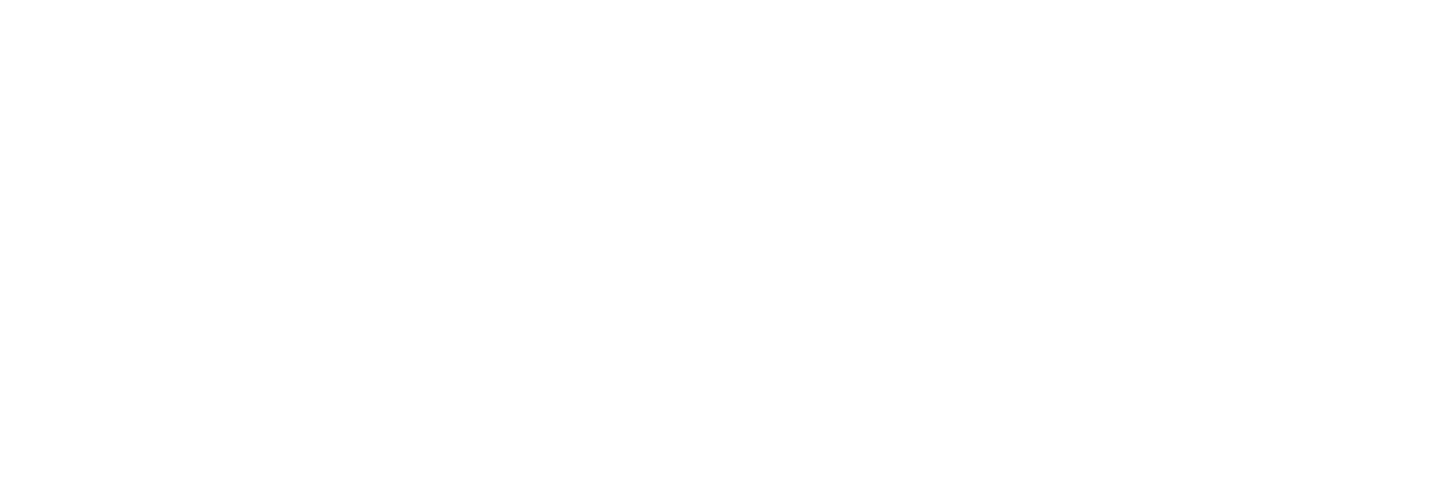

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ..., -3]), array([-31, ...,  31]), array([57, ..., 58]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


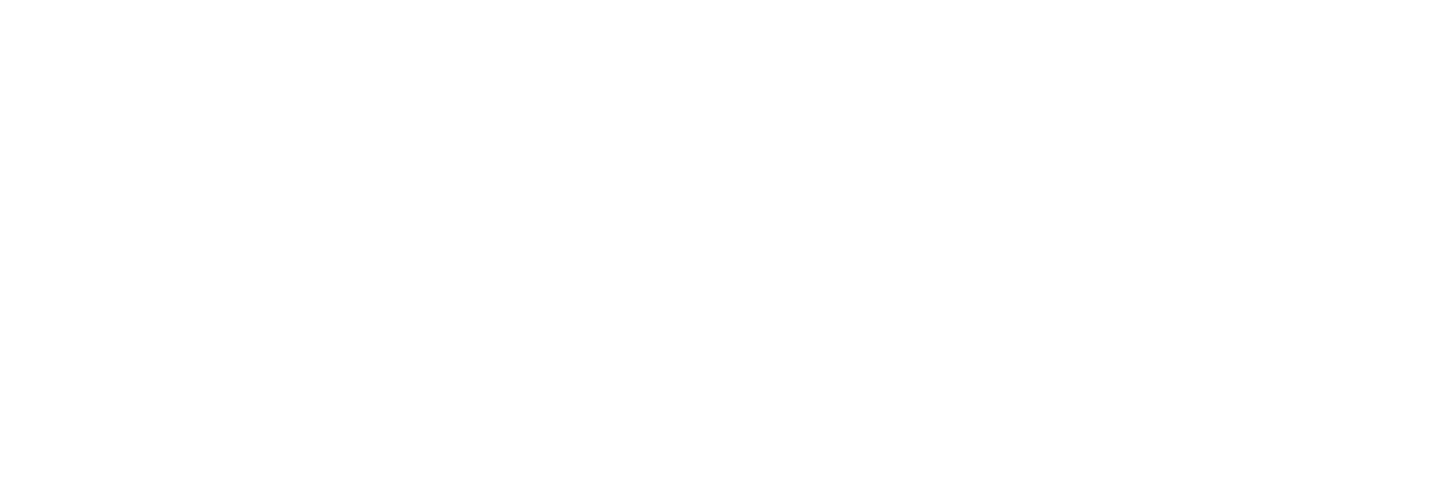

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ..., -4]), array([-30, ...,  31]), array([59, ..., 60]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


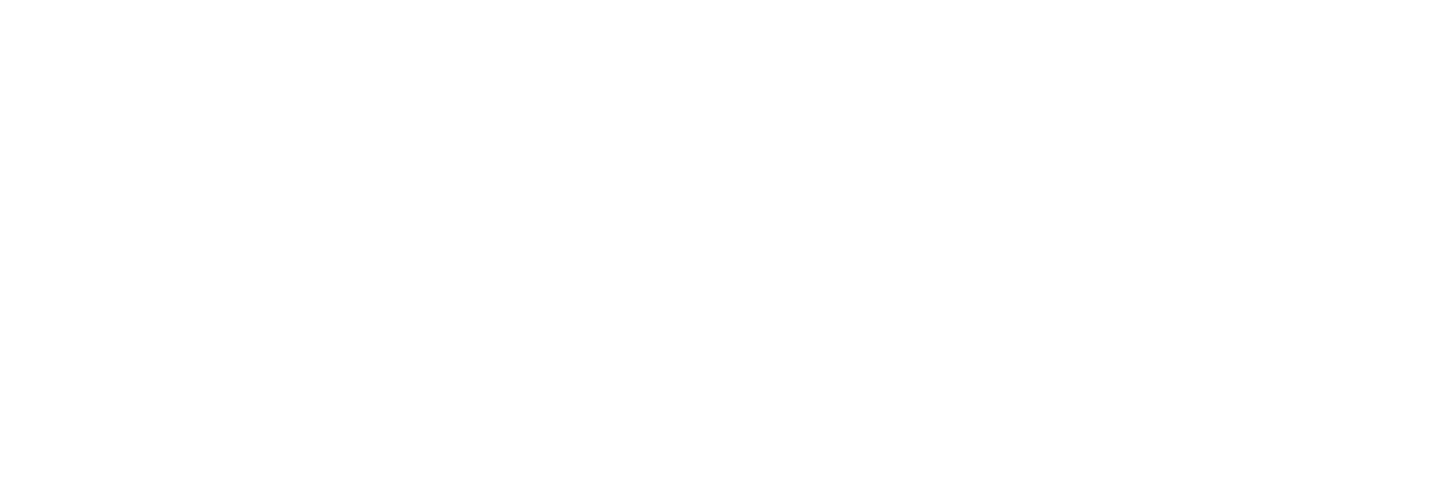

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -5]), array([-32, ...,  32]), array([62, ..., 63]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


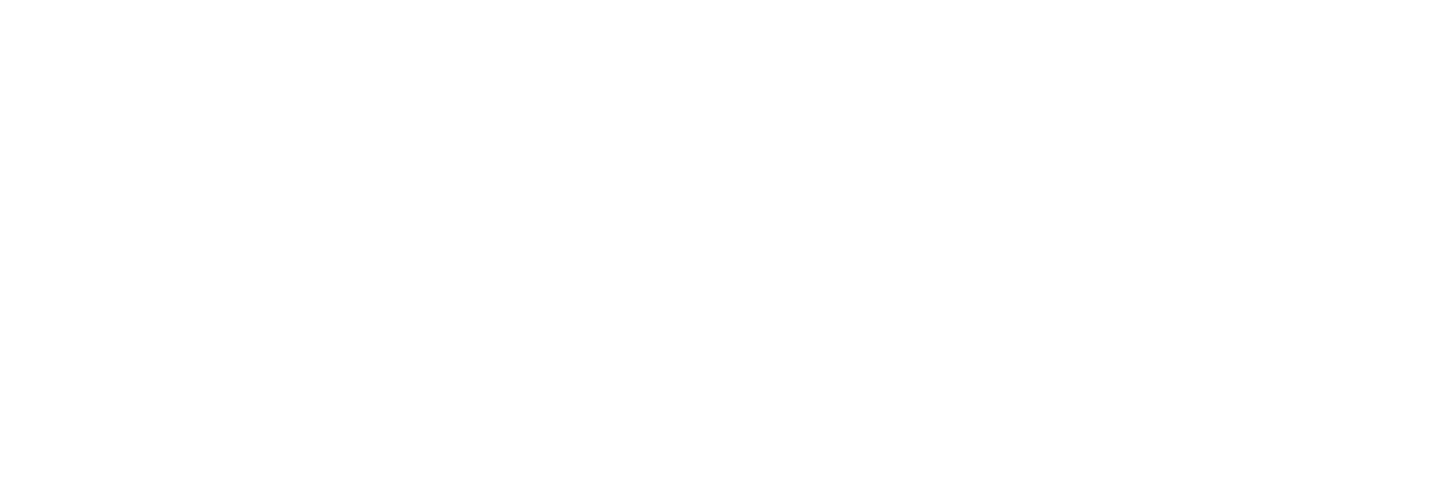

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -4]), array([-31, ...,  31]), array([60, ..., 62]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


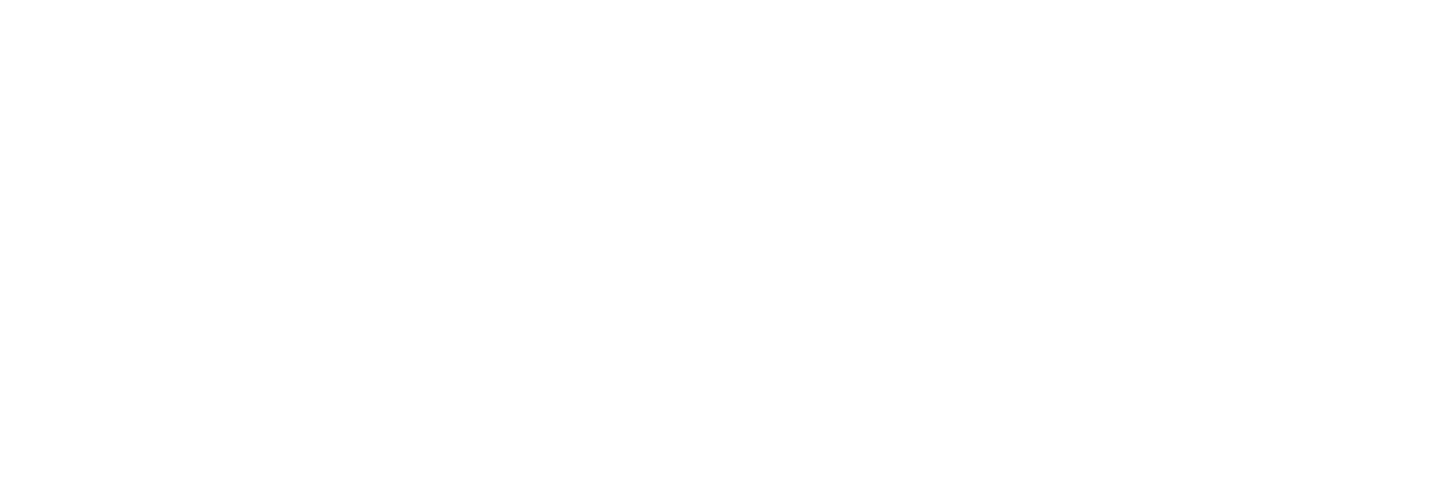

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -3]), array([-29, ...,  29]), array([60, ..., 64]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


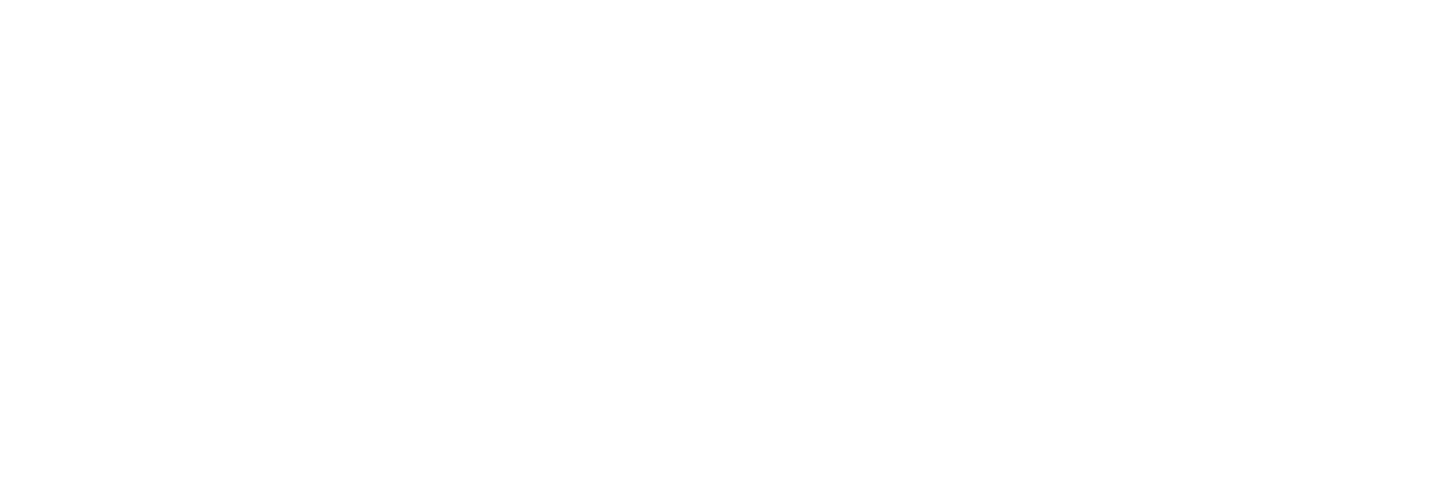

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -3]), array([-27, ...,  27]), array([58, ..., 65]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


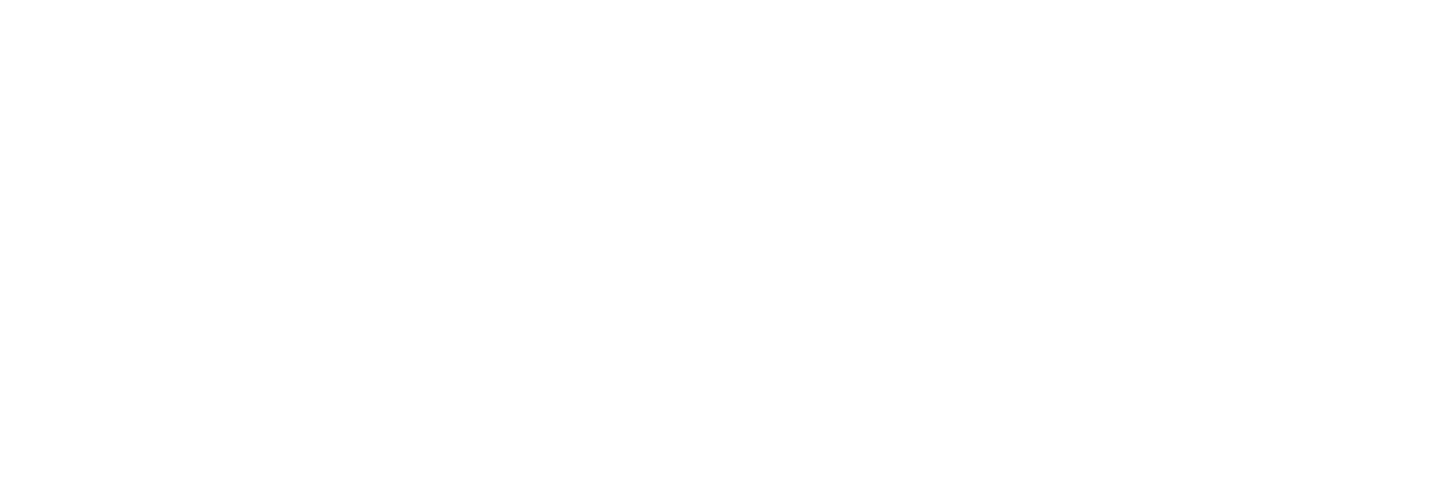

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -3]), array([-27, ...,  26]), array([58, ..., 65]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


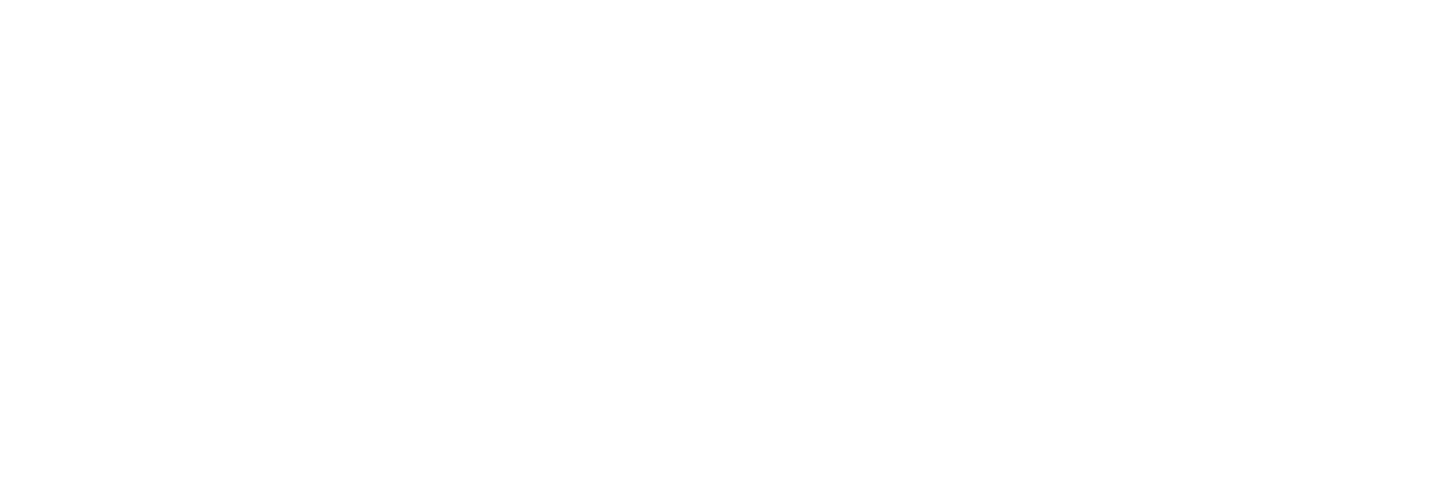

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 0]), array([-28, ...,  26]), array([61, ..., 61]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


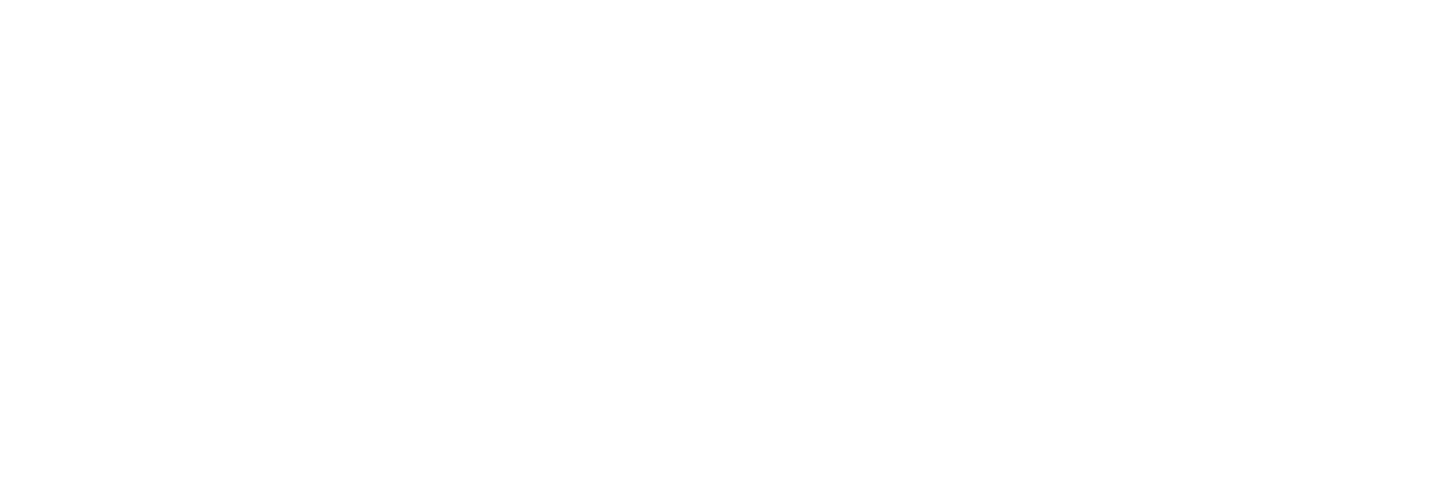

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([1, ..., 1]), array([-28, ...,  26]), array([61, ..., 59]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


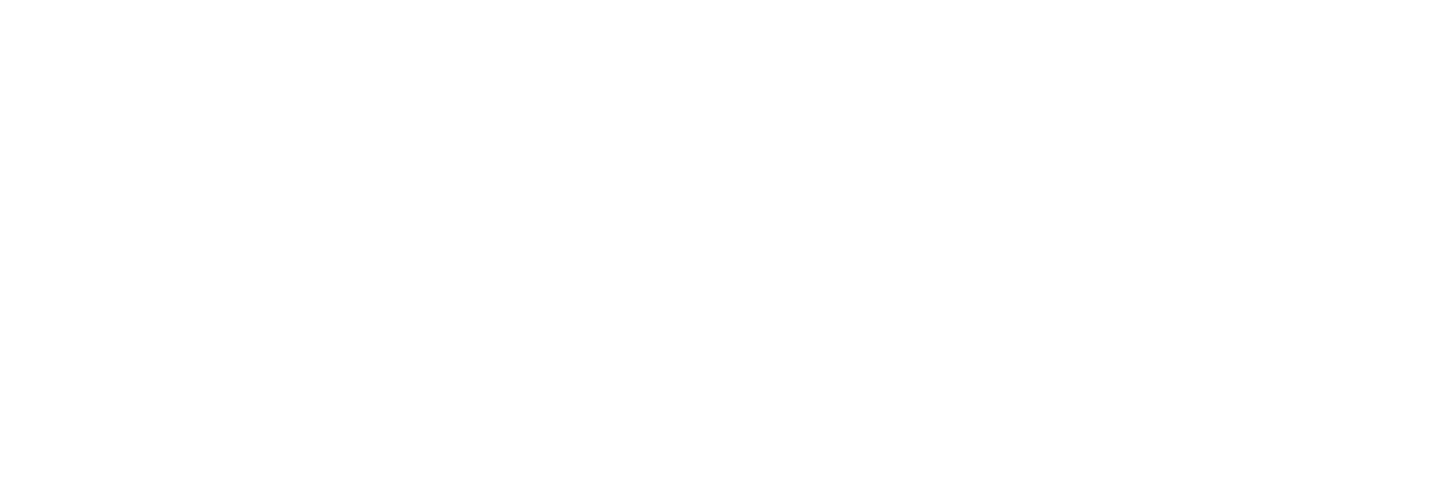

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([1, ..., 1]), array([-26, ...,  26]), array([57, ..., 55]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


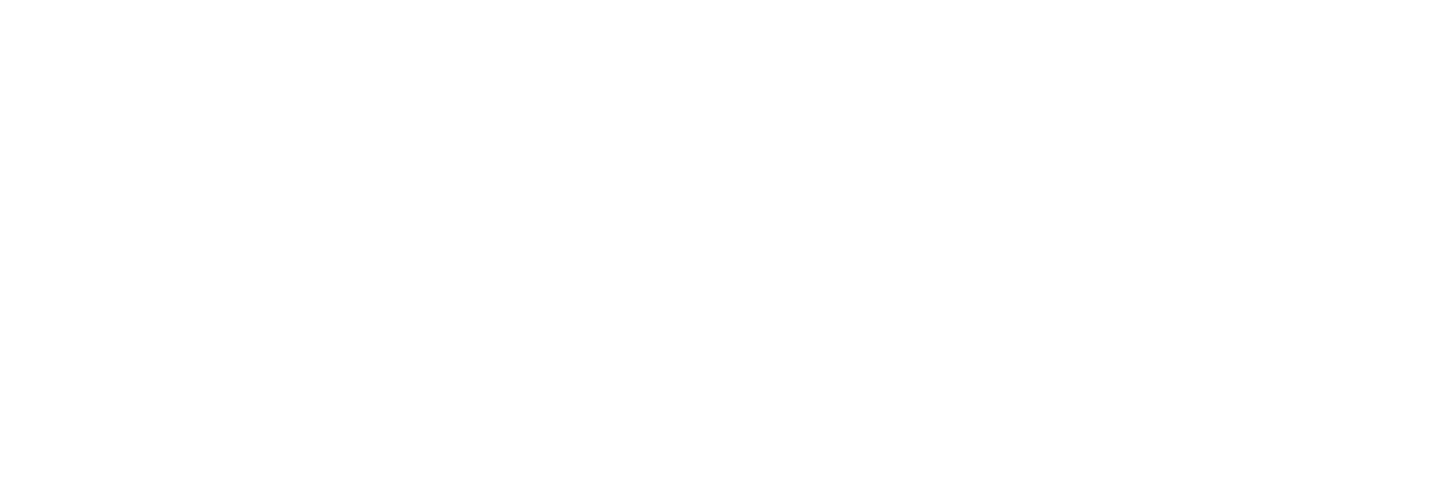

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([2, ..., 0]), array([-25, ...,  24]), array([54, ..., 53]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


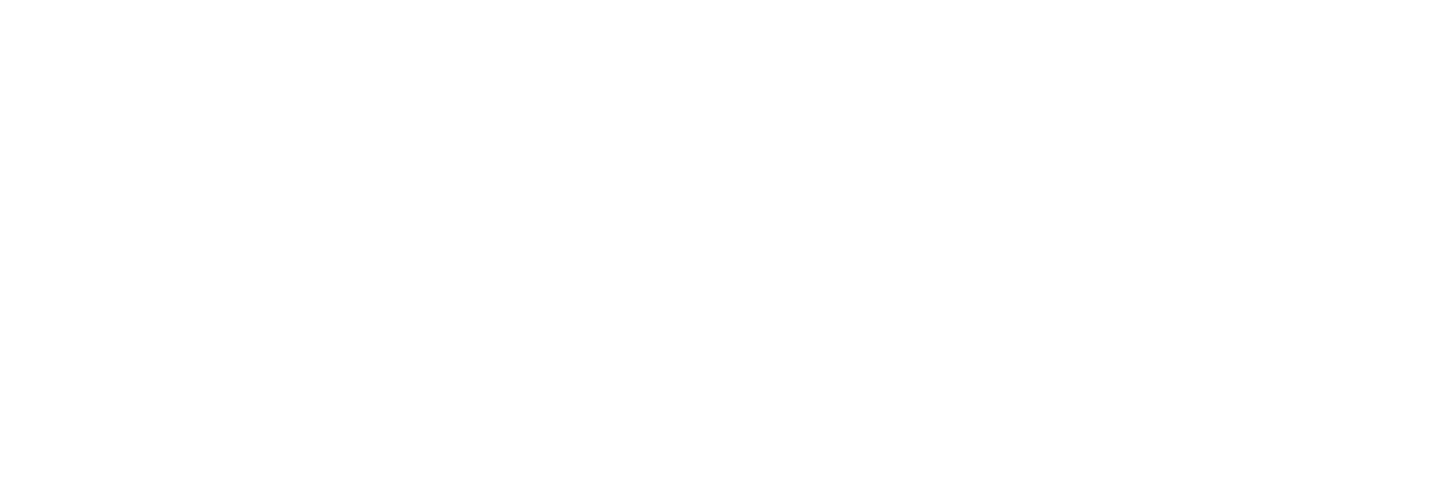

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([5, ..., 2]), array([-29, ...,  25]), array([61, ..., 61]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


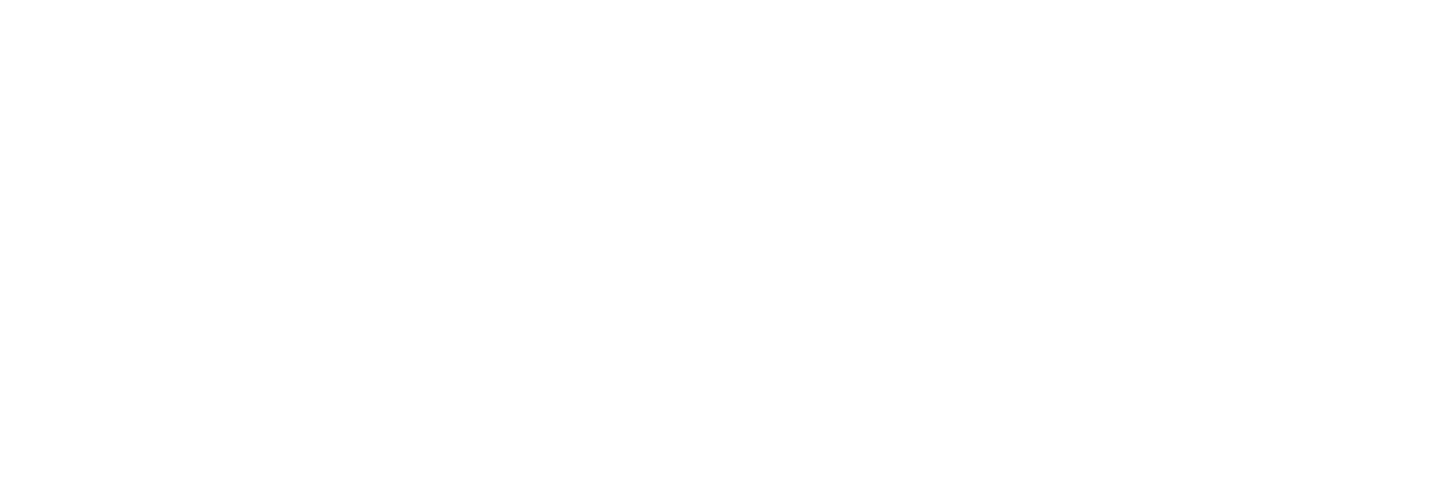

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([8, ..., 6]), array([-34, ...,  30]), array([71, ..., 69]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


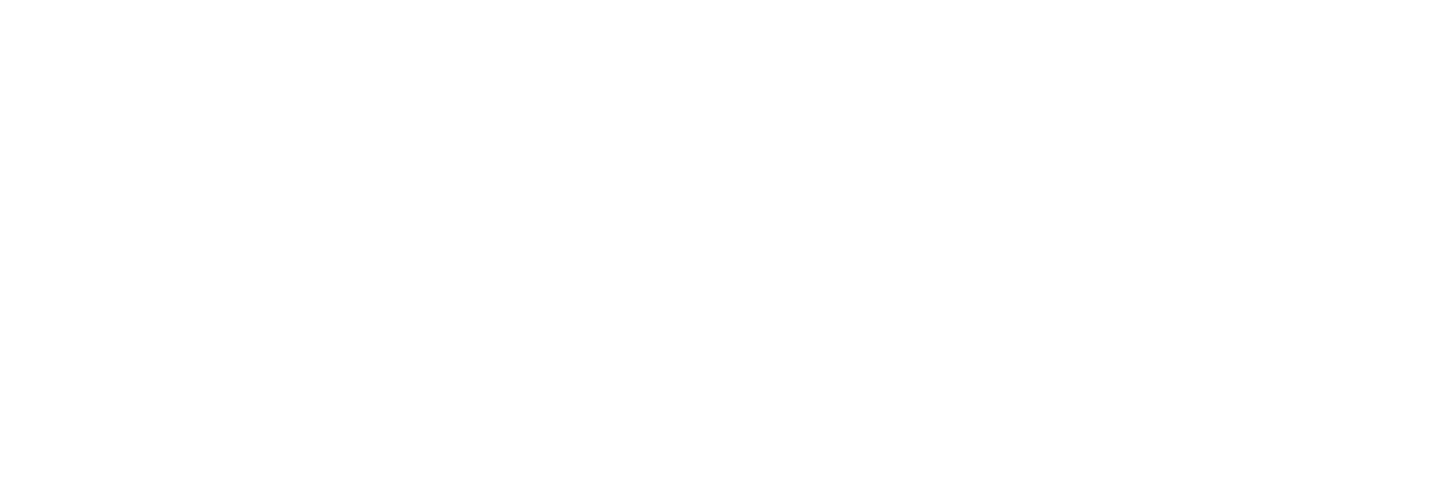

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([8, ..., 4]), array([-34, ...,  27]), array([70, ..., 72]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


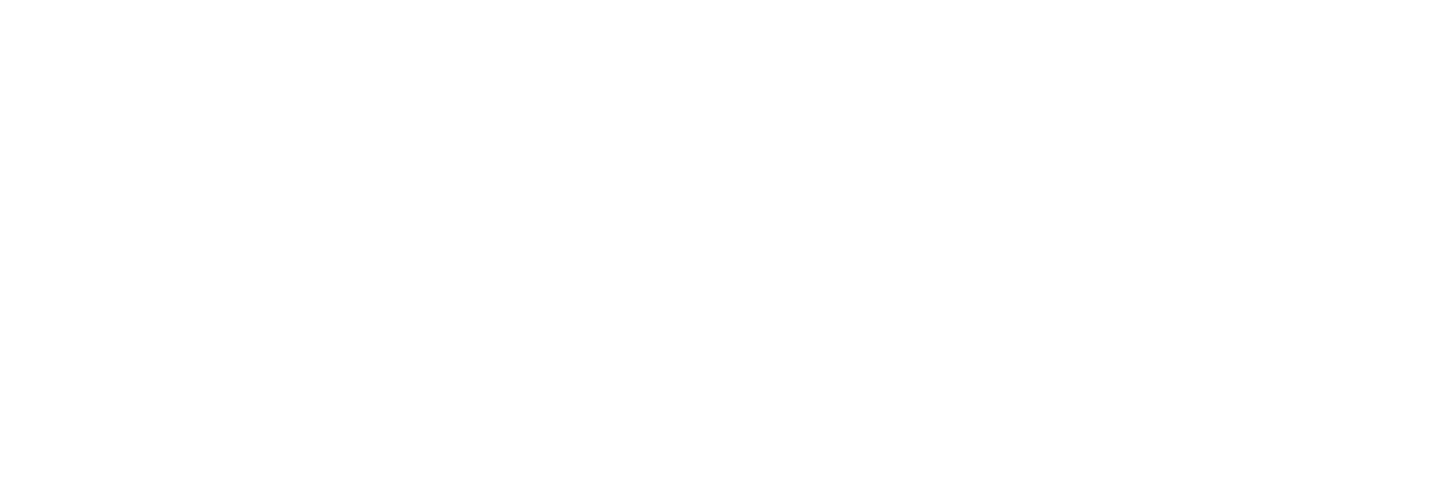

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([7, ..., 1]), array([-32, ...,  22]), array([64, ..., 72]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


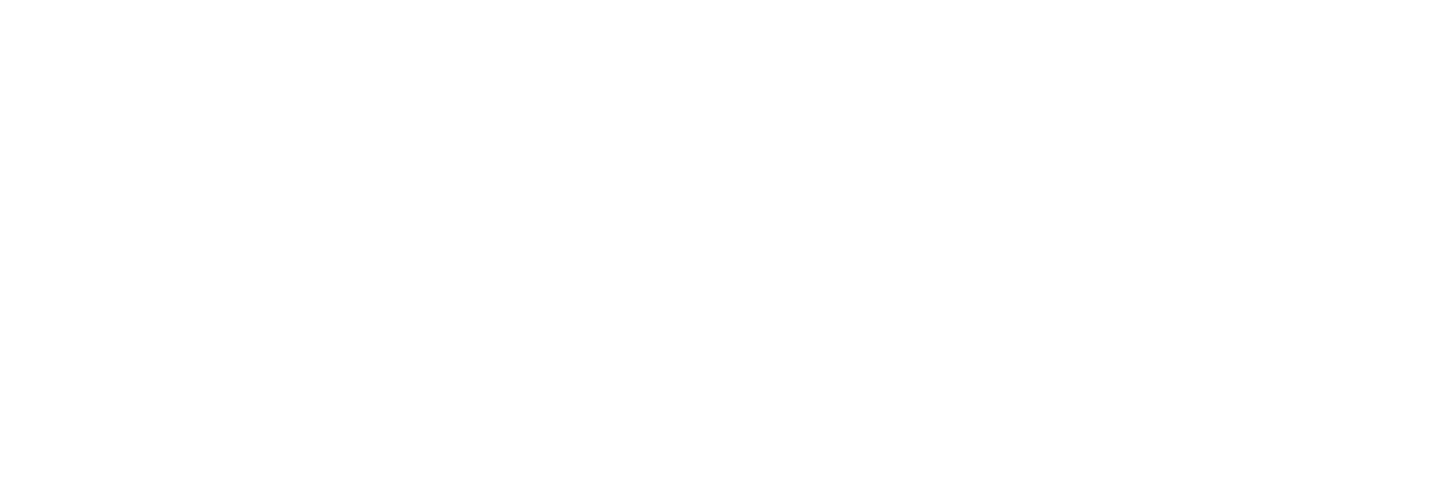

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([7, ..., 0]), array([-30, ...,  19]), array([58, ..., 72]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


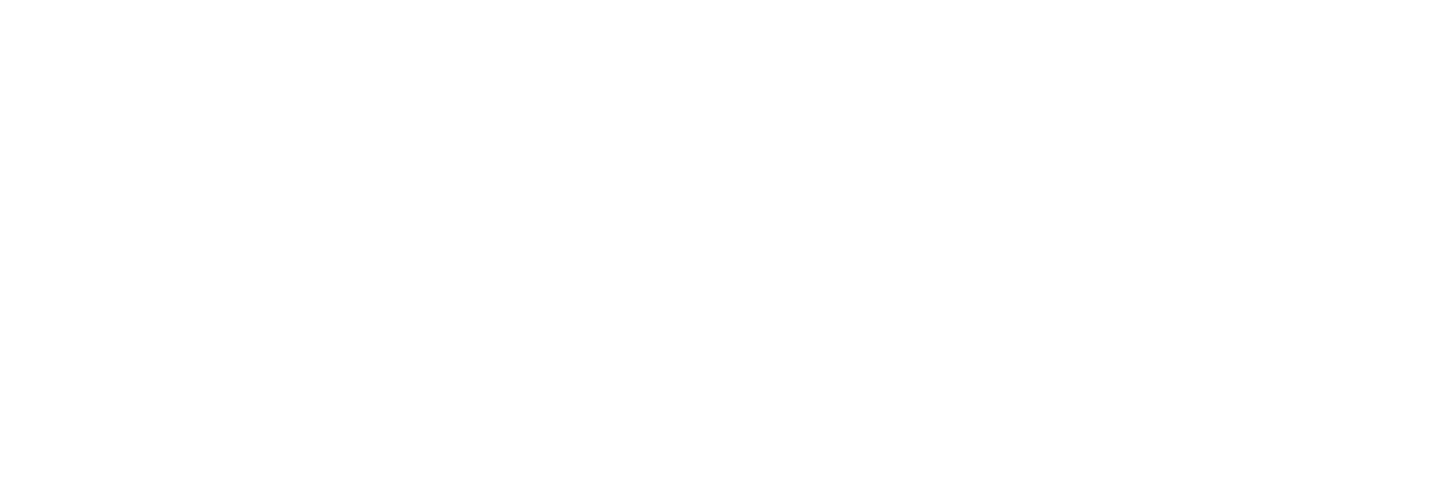

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 7, ..., -1]), array([-30, ...,  18]), array([51, ..., 70]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.7s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


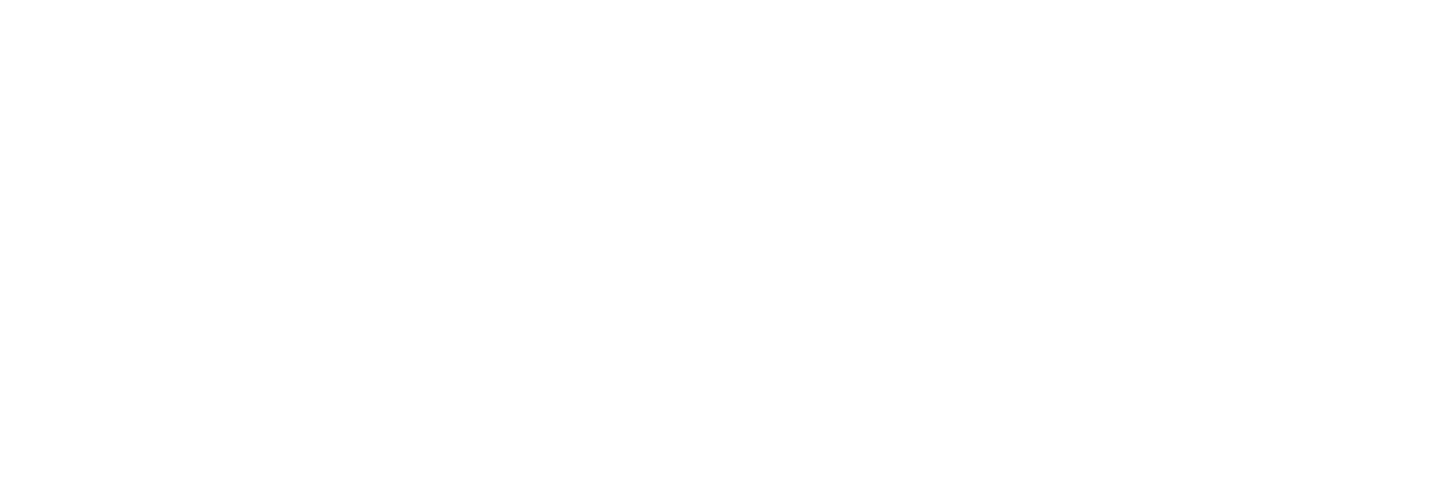

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 6, ..., -2]), array([-31, ...,  19]), array([49, ..., 68]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


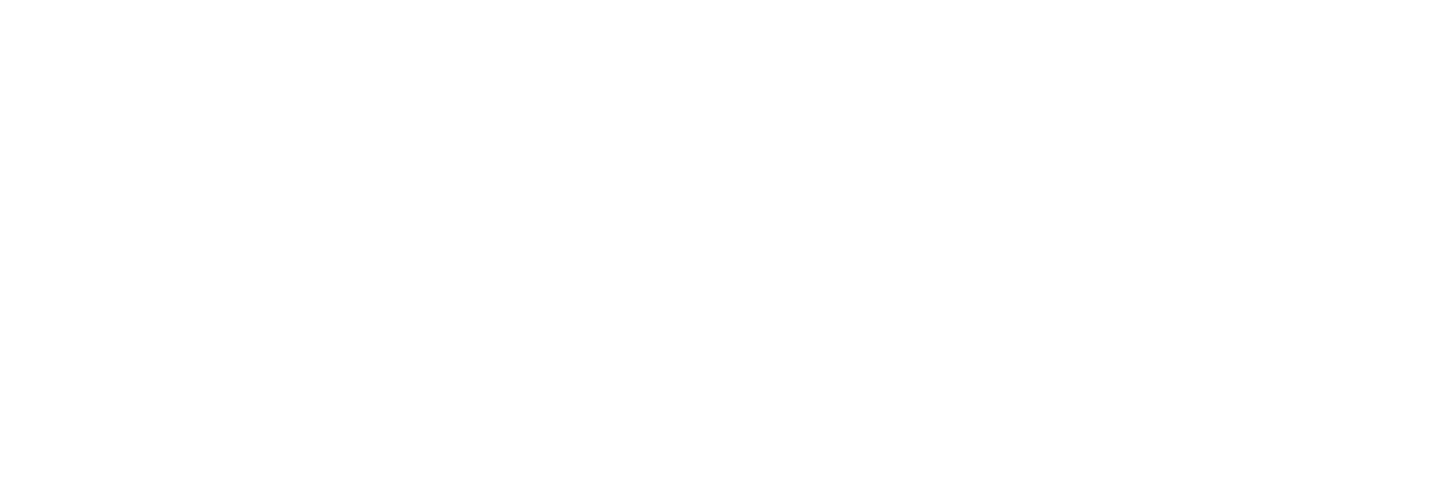

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 5, ..., -3]), array([-33, ...,  22]), array([49, ..., 66]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


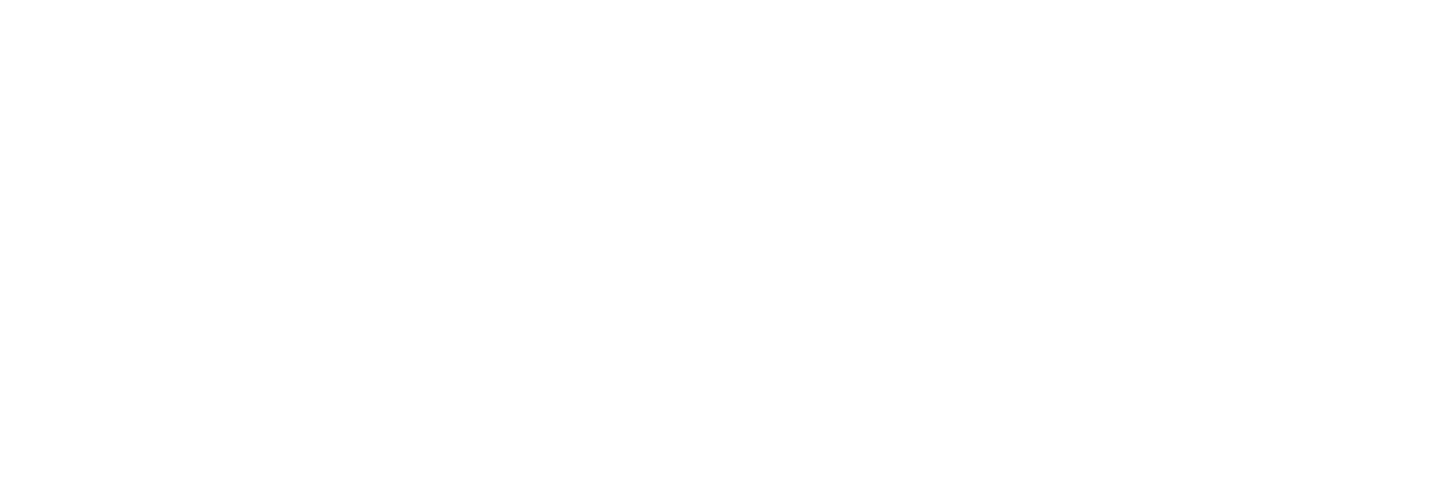

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 3, ..., -4]), array([-33, ...,  23]), array([47, ..., 64]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


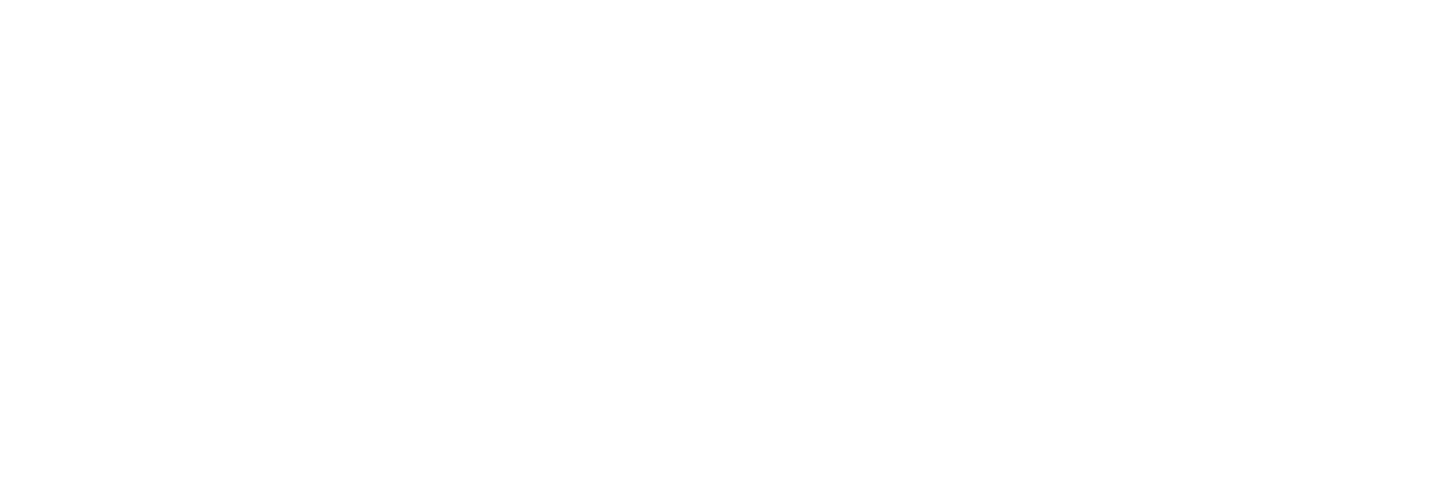

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 1, ..., -6]), array([-30, ...,  22]), array([42, ..., 59]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


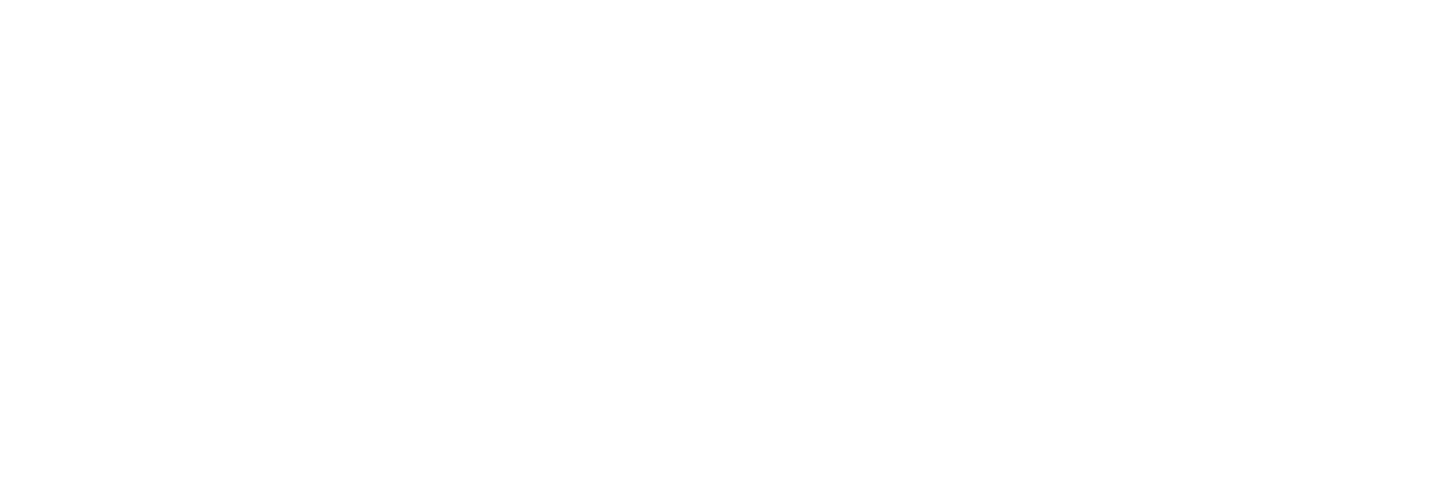

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -5]), array([-28, ...,  21]), array([40, ..., 56]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


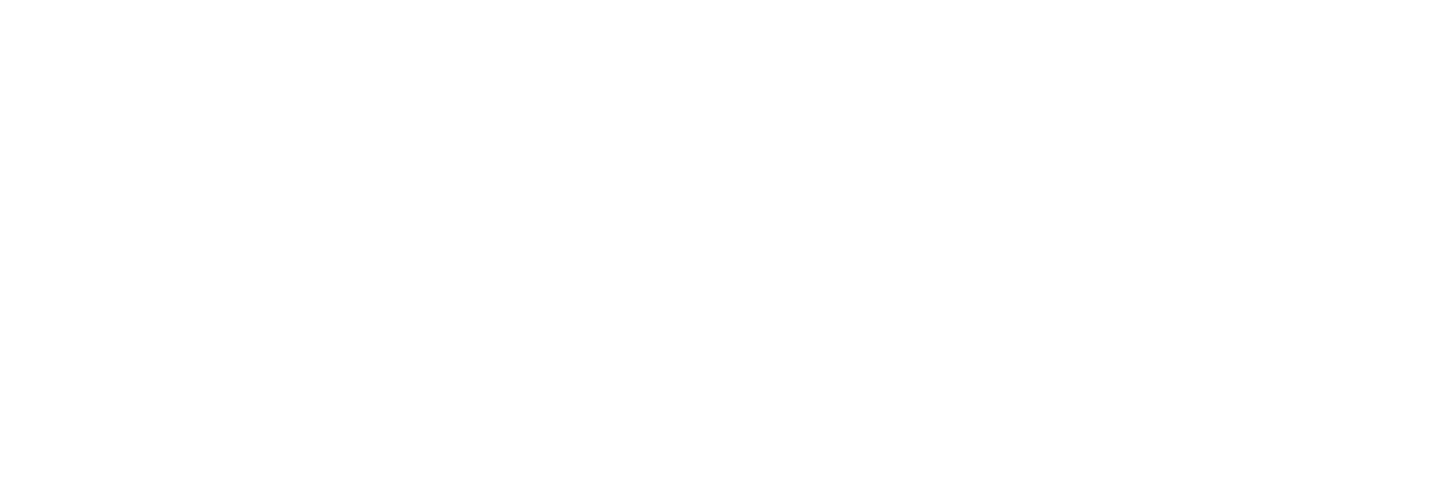

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ..., -4]), array([-31, ...,  25]), array([45, ..., 59]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


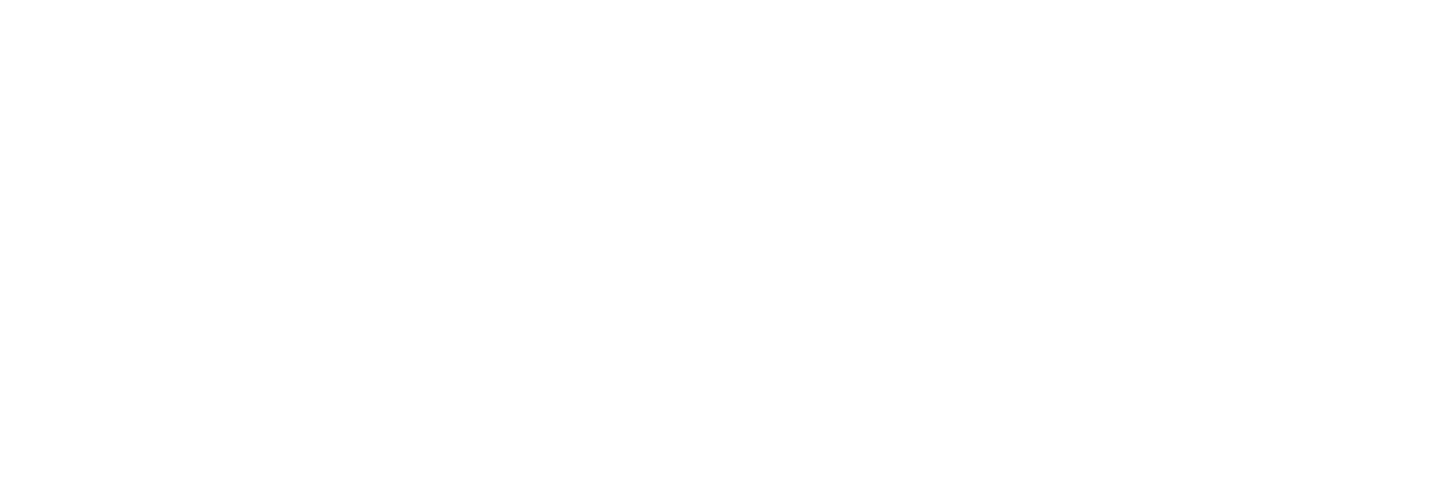

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-3, ..., -3]), array([-31, ...,  23]), array([44, ..., 56]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


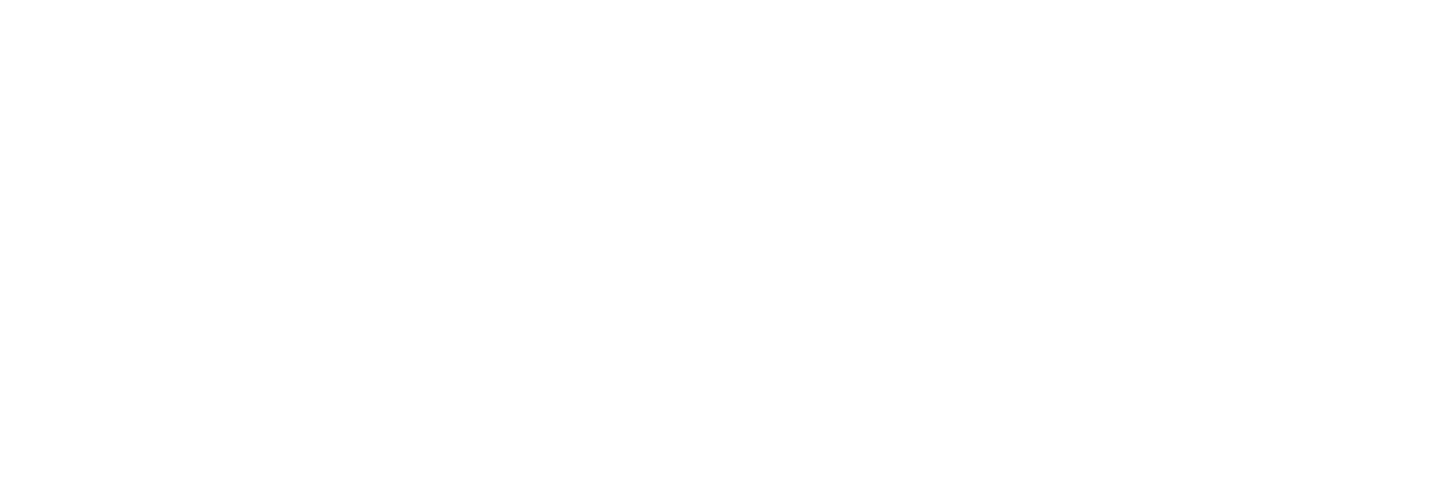

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-2, ..., -5]), array([-28, ...,  22]), array([41, ..., 51]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


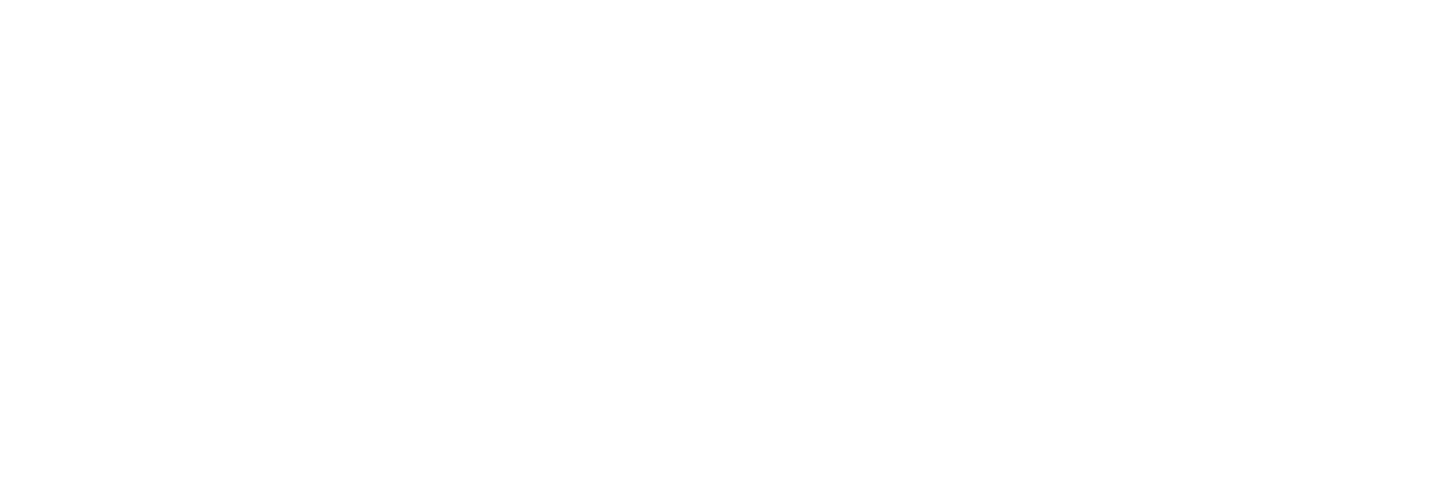

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -5]), array([-26, ...,  22]), array([39, ..., 49]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


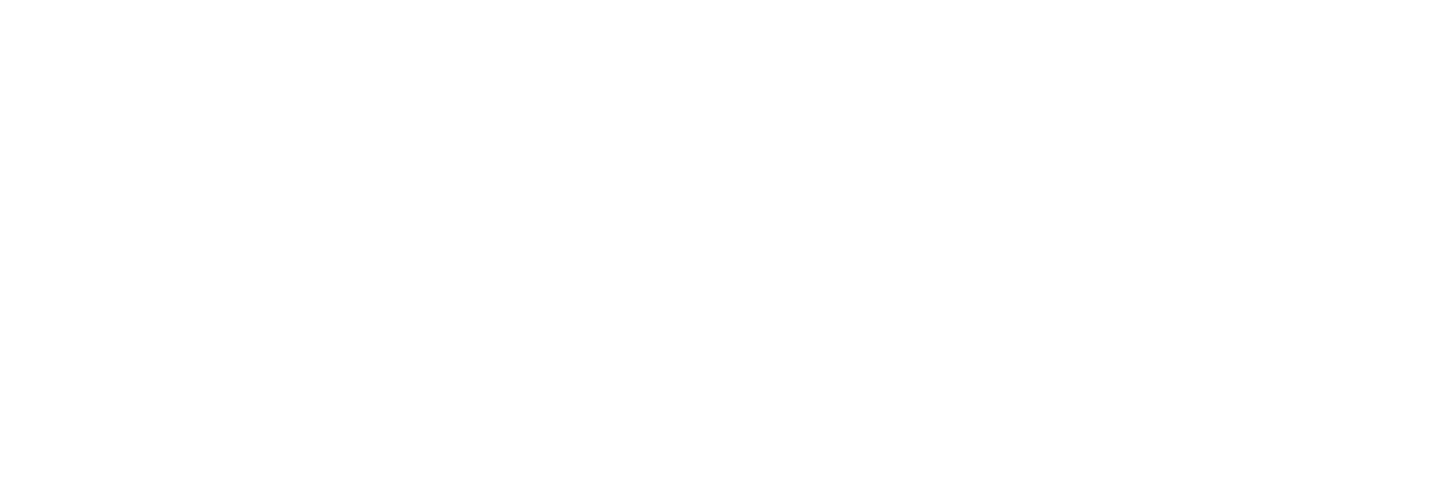

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -3]), array([-25, ...,  23]), array([41, ..., 54]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


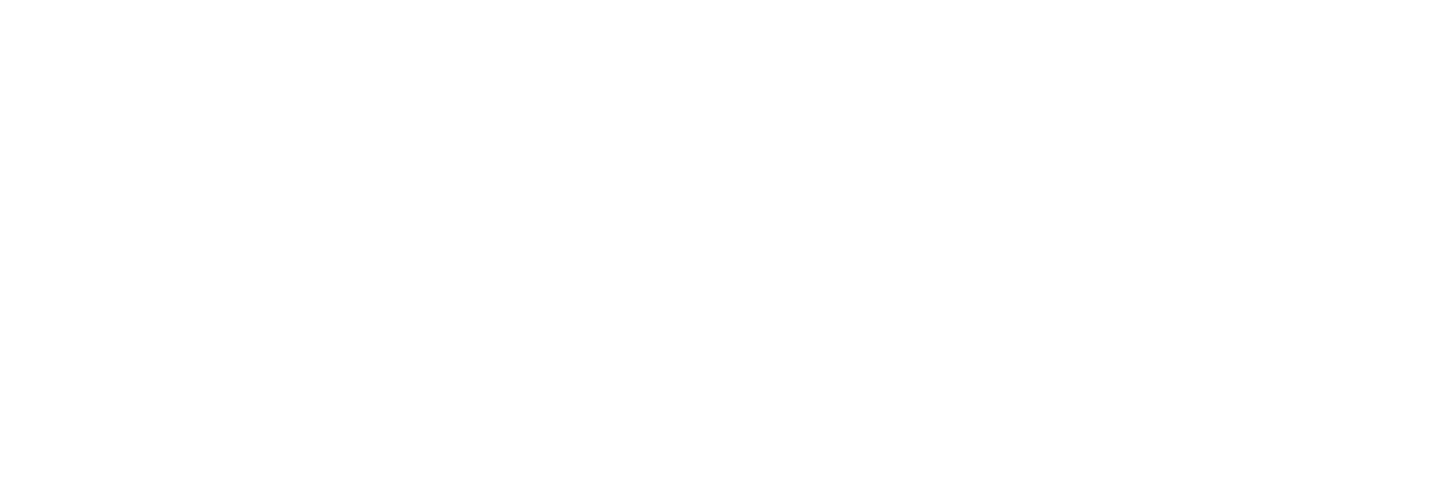

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([ 0, ..., -1]), array([-22, ...,  21]), array([42, ..., 60]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


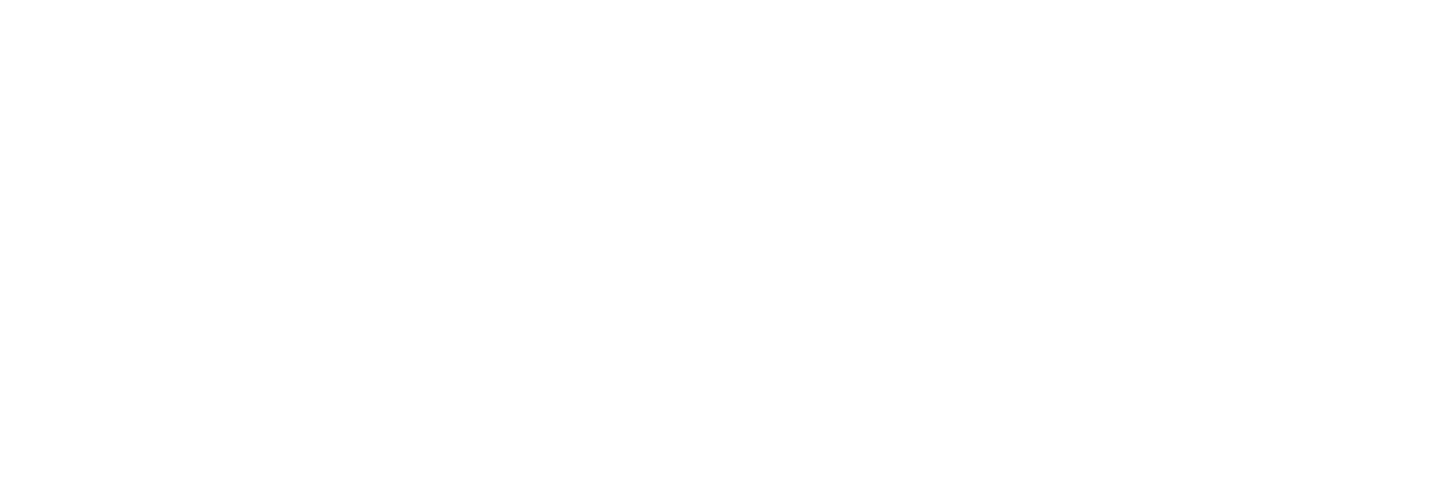

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 0]), array([-19, ...,  20]), array([46, ..., 59]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.7s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


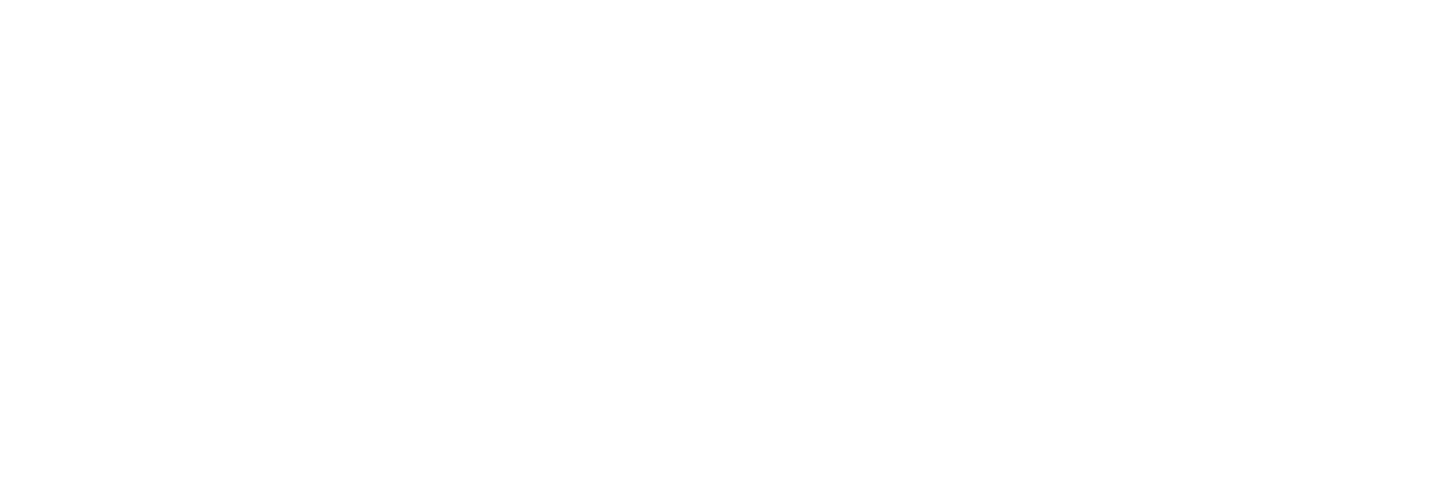

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([0, ..., 1]), array([-16, ...,  18]), array([48, ..., 52]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


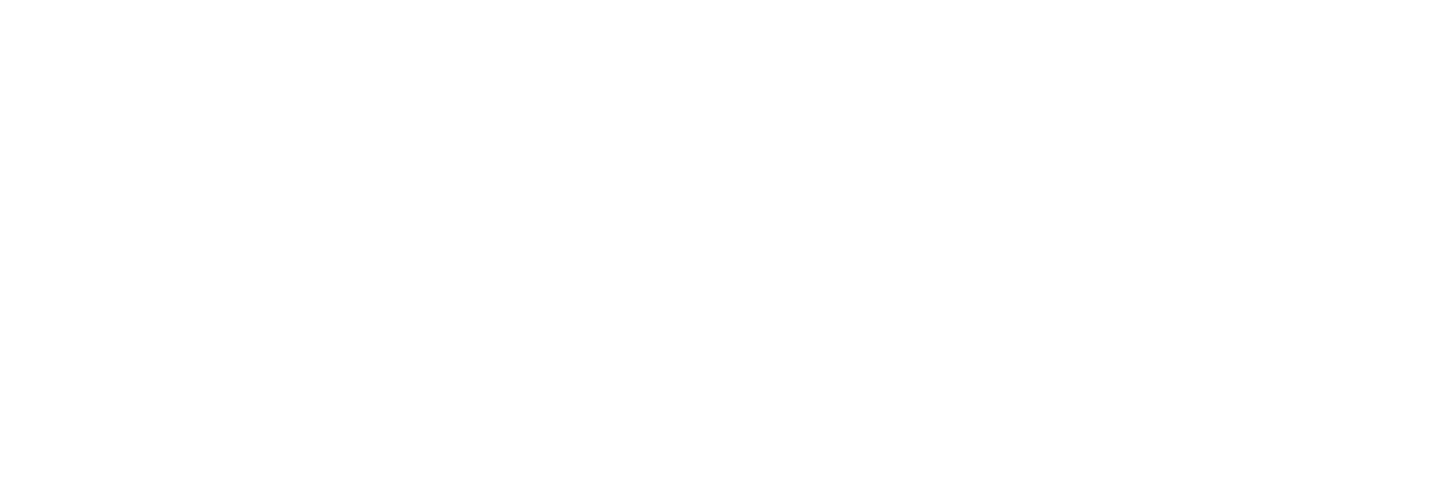

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-1, ...,  0]), array([-13, ...,  18]), array([47, ..., 48]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


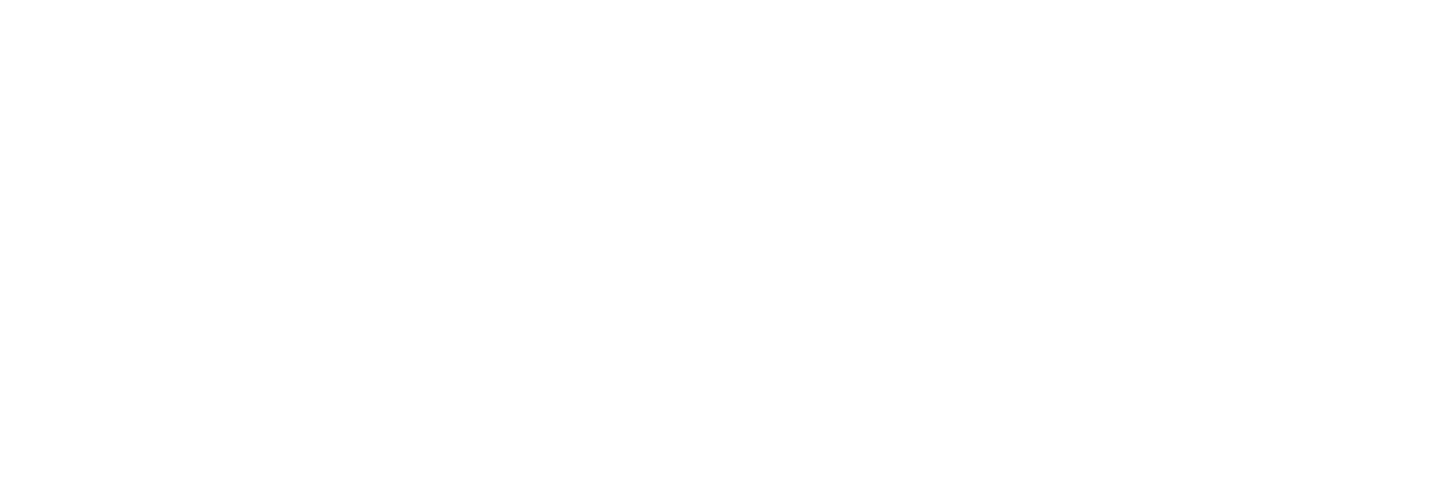

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-4, ..., -2]), array([-12, ...,  18]), array([46, ..., 46]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


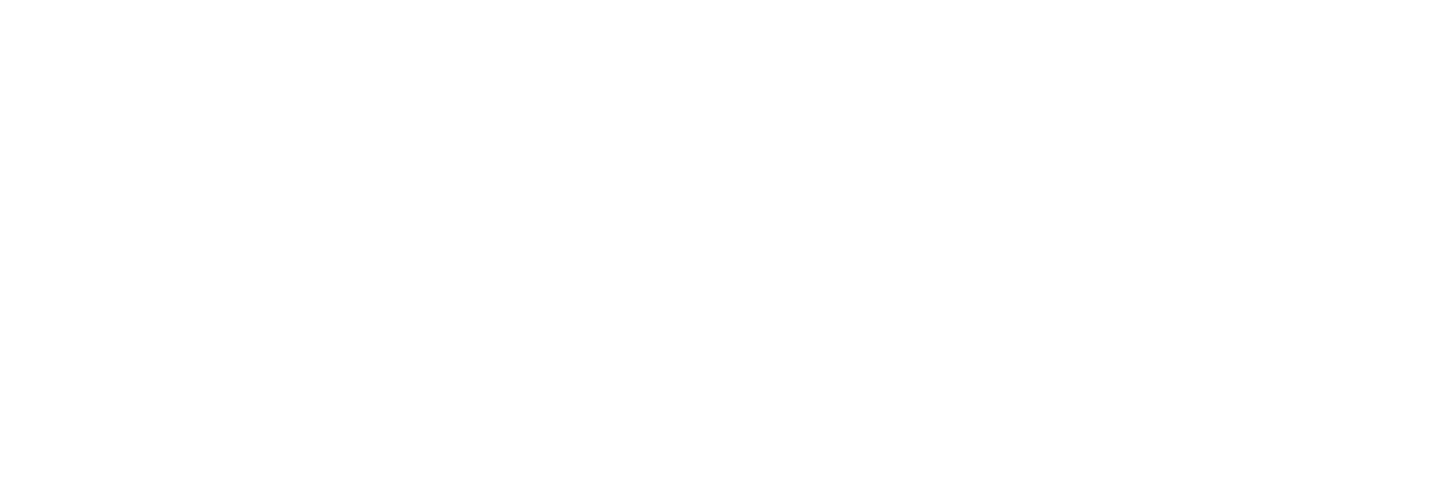

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-6, ..., -2]), array([-12, ...,  19]), array([48, ..., 45]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.7s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


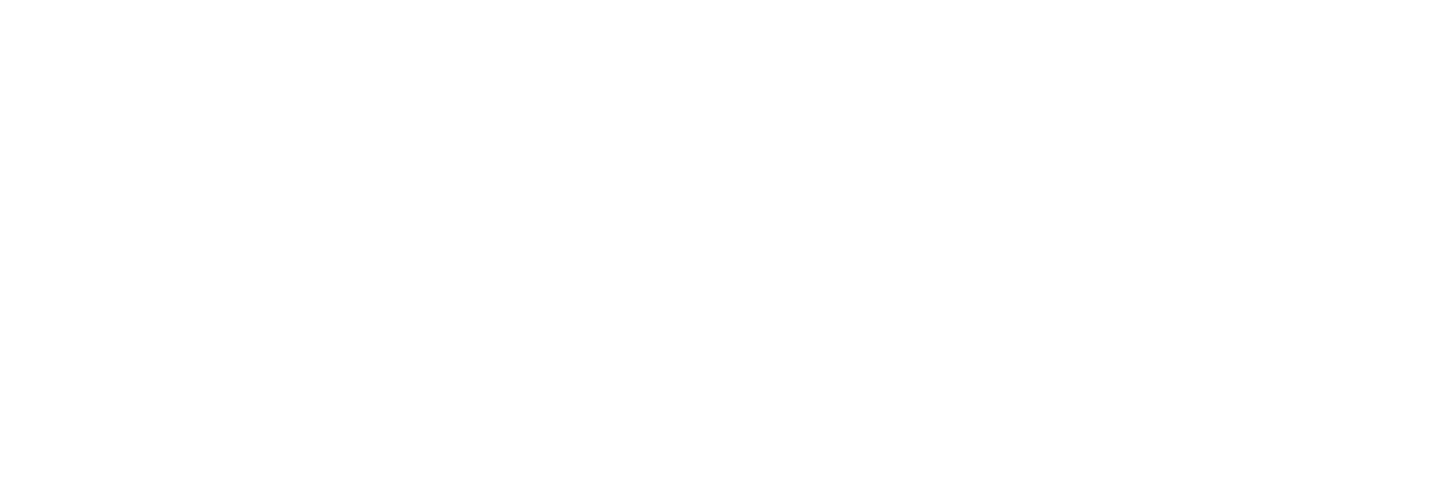

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-7, ..., -2]), array([-14, ...,  18]), array([47, ..., 45]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


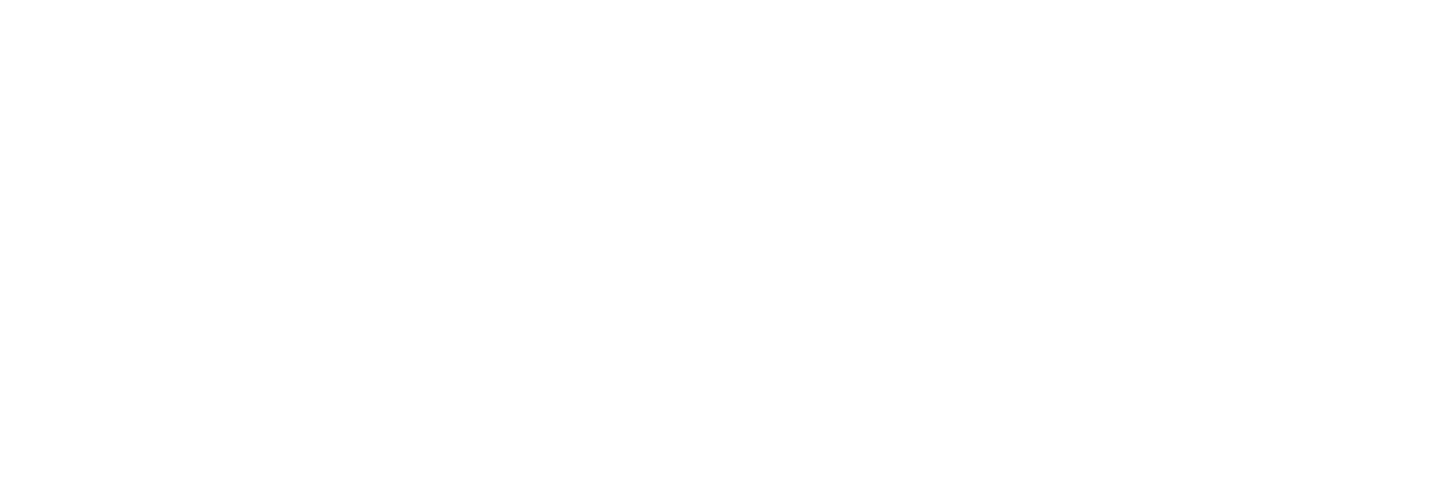

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.450029, ...,  0.452265]), array([-2.046867, ...,  2.165859]), 0.4537856055185257, array([-6, ..., -4]), array([-16, ...,  18]), array([45, ..., 47]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min
20.0 42.0


<IPython.core.display.Javascript object>


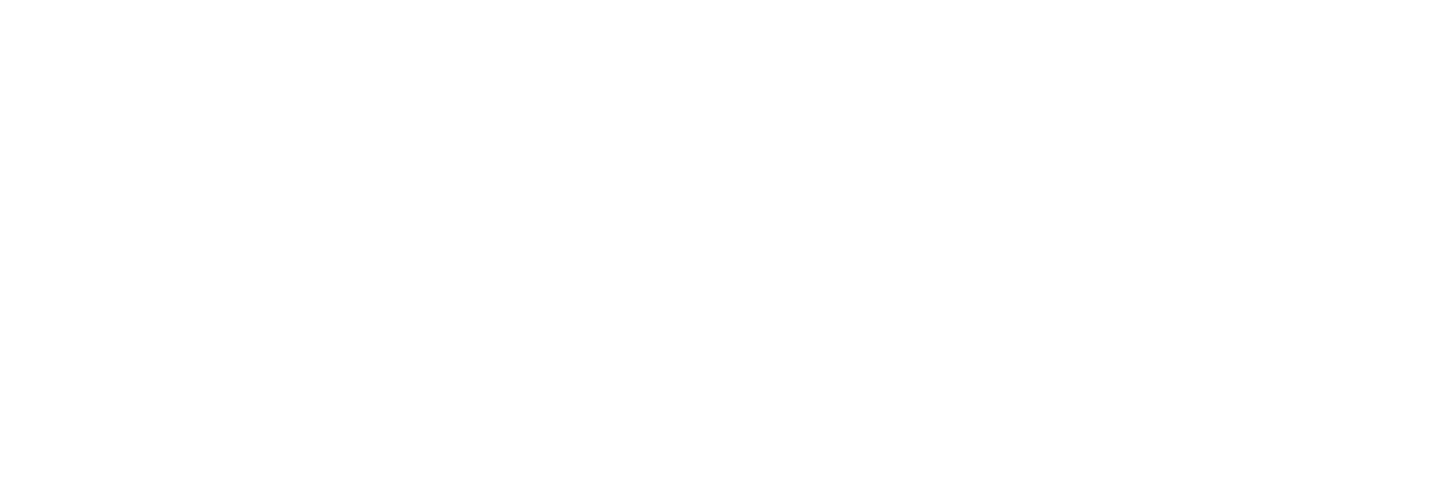

In [25]:
#draw maps (2)

for jj, time in enumerate(times_long):

    timev = numpy.atleast_1d(time)
    times_d, r_d, theta_d, phi_d = coords.anything(numpy.ones_like(theta_in)
                                                   *constants.a_r,
                                                   theta_in,
                                                   phi_in,
                                                   timev)

    r_dg, theta_dg, phi_dg = trig.geo2sph(theta_d, phi_d)
    r_dgr, theta_dgr, phi_dgr = scha.rotate_coords(r_dg, theta_dg, 
                                                   phi_dg, rot_mat)
    
    D_m, I_m, F_m = model.synth_data(times_d, r_d, theta_d, phi_d, g)
    
    fig = field_plots.component_residual_plot(
                    theta_dgr, phi_dgr,
                    model.theta_0p,
                    theta_c, phi_c,
                    (numpy.rad2deg(D_m), numpy.rad2deg(I_m), F_m),
                    scales=("symmetric", "positive", "positive"),
                    cmaps=("Spectral", "Spectral", "Spectral"),
                    titles=("", "", ""),
                    cbar=False,
                    lines=0, nlevels=25,
                    lims=((-50, 50), (0, 90), (30, 80)))
    
    t_ind = (time - 200 < model.tv) & (model.tv < time + 200)
    base_world.scatter(numpy.rad2deg(model.phiv)[~model.nan_D & t_ind],
                   90-numpy.rad2deg(model.thetav)[~model.nan_D & t_ind],
                   c=numpy.rad2deg(model.D_o[~model.nan_D & t_ind]),
                   s=17,
                   edgecolors="black",
                   linewidths=0.3,
                   cmap="Spectral",
                   norm=pyplot.Normalize(-50, 50),
                   latlon=True, ax=fig.axes[0])
    
    base_world.scatter(numpy.rad2deg(model.phiv)[~model.nan_I & t_ind],
                   90-numpy.rad2deg(model.thetav)[~model.nan_I & t_ind],
                   c=numpy.rad2deg(model.I_o[~model.nan_I & t_ind]),
                   s=17,
                   edgecolors="black",
                   linewidths=0.3,
                   cmap="Spectral",
                   norm=pyplot.Normalize(0, 90),
                   latlon=True, ax=fig.axes[1])
    
    base_world.scatter(numpy.rad2deg(model.phiv)[~model.nan_F & t_ind],
                   90-numpy.rad2deg(model.thetav)[~model.nan_F & t_ind],
                   c=model.F_o[~model.nan_F & t_ind],
                   s=17,
                   edgecolors="black",
                   linewidths=0.3,
                   cmap="Spectral",
                   norm=pyplot.Normalize(30, 80),
                   latlon=True, ax=fig.axes[2])
    #fig.suptitle('t = {} years AD'.format(time))
    fig.savefig(savepath+'/rscha2d_{jj:04d}_{time:d}.png'.format(jj=jj, time=int(time)),
                frameon=True)
    pyplot.close(fig)

In [26]:
def location_curves(latd, lond, name):
    theta_at, phi_at = numpy.deg2rad((90-latd, lond))

    near = (trig.angulardist(theta_at, phi_at, model.thetav, model.phiv) 
            < numpy.arctan(900/constants.a_r))

    D_reloc, I_reloc, F_reloc = trig.relocate(model.D_o, model.I_o, model.F_o,
                                              model.thetav, model.phiv, theta_at, phi_at)
    
    t_cur = numpy.linspace(-2100, 1950, 400)
    t_cur, r_cur, theta_cur, phi_cur = coords.curve_at(t_cur, constants.a_r, theta_at, phi_at)
    
    D_cur_boot = numpy.zeros((len(t_cur), n_samples))
    I_cur_boot = D_cur_boot.copy()
    F_cur_boot = D_cur_boot.copy()

    for i, g in zip(range(n_samples), gs):
        D_cur_boot[:, i], I_cur_boot[:,i], F_cur_boot[:,i] = (
            model.synth_data(t_cur, r_cur, theta_cur, phi_cur, g)
        )
        print(gauge.gauge(i+1, n_samples), end="\r")
    
    g_zero = numpy.zeros_like(g)
    curves_zero = model.synth_data(t_cur, r_cur, theta_cur, phi_cur, g_zero)
    
    D_avg = numpy.average(D_cur_boot, axis=1)
    I_avg = numpy.average(I_cur_boot, axis=1)
    F_avg = numpy.average(F_cur_boot, axis=1)

    D_std = numpy.std(D_cur_boot, axis=1)
    I_std = numpy.std(I_cur_boot, axis=1)
    F_std = numpy.std(F_cur_boot, axis=1)
    
    fig, (ax0, ax1, ax2) = pyplot.subplots(3,1, figsize=(8,9),
                                       gridspec_kw = {"height_ratios" : [1, 1, 1]})

    common={"marker" : ".", "s" : 1, "alpha" : 0.8, "color" : "xkcd:black"}
    sha_style = {"color" : "xkcd:dark red", "linestyle" : "--", "linewidth" : 2}
    rscha_style = {"color" : "xkcd:light red", "alpha" : 0.005}

    curve_color = "xkcd:light red"
    curve_style = {"linewidth" : 1.5}
    curve_style_2 = {"linewidth" : 1.5, "linestyle" : ":", "color" : "teal"}
    curve_style_3 = {"linewidth" : 1, "linestyle" : "--"}

    ax0.set_ylabel("D (°)")
    ax1.set_ylabel("I (°)")
    ax2.set_ylabel("F ($\mu $T)")
    ax0.set_title("@{}".format(name))

    cmap = pyplot.cm.viridis

    ax0.scatter(model.tv[near], numpy.rad2deg(D_reloc)[near], **common)
    #for cv in D_cur_boot.T:
    #    ax0.plot(t_cur, numpy.rad2deg(cv), **curve_style, color="blue", alpha=0.1)
    ax0.plot(t_cur, numpy.rad2deg(D_avg), **curve_style, color="xkcd:hot pink")
    ax0.plot(t_cur, numpy.rad2deg(D_avg + D_std), **curve_style_3, color="xkcd:hot pink")
    ax0.plot(t_cur, numpy.rad2deg(D_avg - D_std), **curve_style_3, color="xkcd:hot pink")
    ax0.plot(t_cur, numpy.rad2deg(D_avg), **curve_style, color="xkcd:hot pink")
    ax0.plot(t_cur, numpy.rad2deg(curves_zero[0]), **curve_style_2)
    ax0.set_ybound(numpy.min(numpy.rad2deg(D_avg))-10, numpy.max(numpy.rad2deg(D_avg))+10)

    ax1.scatter(model.tv[near], numpy.rad2deg(I_reloc)[near], **common)
    #for cv in I_cur_boot.T:
    #    ax1.plot(t_cur, numpy.rad2deg(cv), **curve_style, color="blue", alpha=0.1)
    ax1.plot(t_cur, numpy.rad2deg(I_avg), **curve_style, color="xkcd:hot pink")
    ax1.plot(t_cur, numpy.rad2deg(I_avg + I_std), **curve_style_3, color="xkcd:hot pink")
    ax1.plot(t_cur, numpy.rad2deg(I_avg - I_std), **curve_style_3, color="xkcd:hot pink")
    ax1.plot(t_cur, numpy.rad2deg(curves_zero[1]), **curve_style_2)
    ax1.set_ybound(numpy.min(numpy.rad2deg(I_avg))-10, numpy.max(numpy.rad2deg(I_avg))+10)

    ax2.scatter(model.tv[near], F_reloc[near], **common)
    #for cv in F_cur_boot.T:
    #    ax2.plot(t_cur, cv, **curve_style, color="blue", alpha=0.1)
    ax2.plot(t_cur, F_avg, **curve_style, color="xkcd:hot pink")
    ax2.plot(t_cur, F_avg + F_std, **curve_style_3, color="xkcd:hot pink")
    ax2.plot(t_cur, F_avg - F_std, **curve_style_3, color="xkcd:hot pink")
    ax2.plot(t_cur, curves_zero[2], **curve_style_2)
    ax2.set_ybound(numpy.min(F_avg)-10, numpy.max(F_avg)+10)
    ax2.set_xlabel("Time (years AD)")
    
    for ax in (ax0, ax1, ax2):
        ax.set_xbound(-2000, 1900)
        ax.set_facecolor("white")

    return fig

<IPython.core.display.Javascript object>


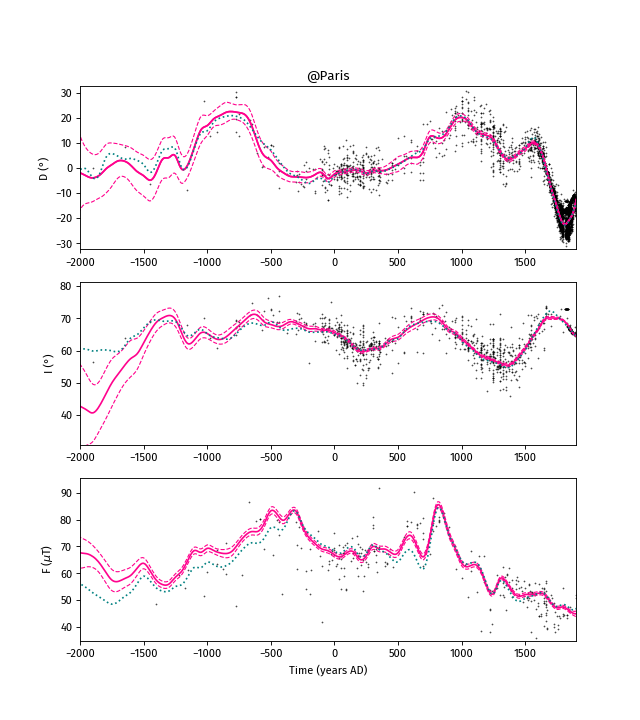

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.044485, ...,  0.044485]), array([ 1.864357, ...,  1.864357]), 0.4537856055185257, array([-8.728177, ..., -5.022301]), array([ 26.205785, ...,  28.814618]), array([ 44.62941 , ...,  40.732604]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min


<IPython.core.display.Javascript object>


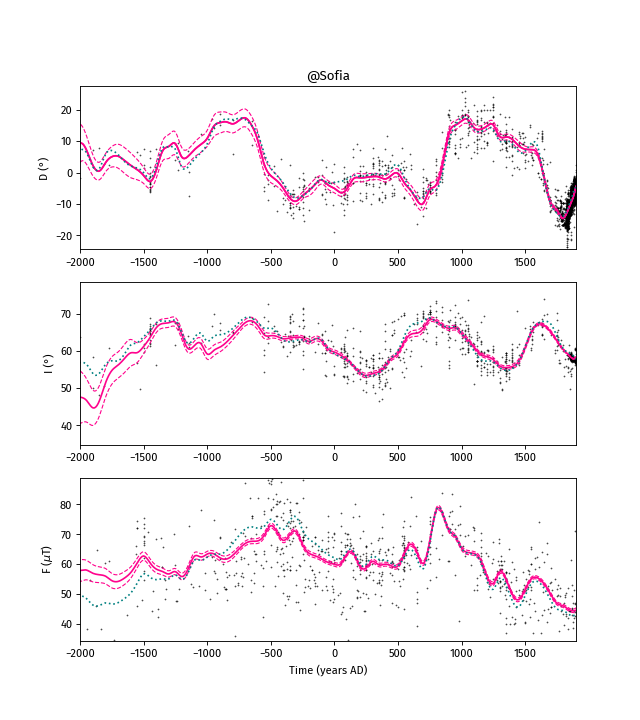

________________________________________________________________________________
[Memory] Calling rscha_r.rscha_condition_matrix_dif...
rscha_condition_matrix_dif(( array([ 0.,  1.,  1.,  2.,  2.,  2.]),
  array([ 0.,  1., -1.,  0.,  2., -2.]),
  array([  1.164403e-12,   3.646726e+00,   3.646726e+00,   7.958865e+00,
         6.368397e+00,   6.368397e+00])), 
( array([ 1.,  1.,  2.,  2.,  2.]),
  array([ 1., -1.,  0.,  2., -2.]),
  array([ 3.646726,  3.646726,  7.958865,  6.368397,  6.368397])), 
array([ 0,  1, -1,  2, -2]), array([ 6371.2, ...,  6371.2]), array([ 0.205125, ...,  0.205125]), array([-2.577753, ..., -2.577753]), 0.4537856055185257, array([-19.825334, ..., -19.865114]), array([-15.834819, ..., -12.644798]), array([ 54.553245, ...,  50.066345]), 50.538353159220478)
_______________________________________rscha_condition_matrix_dif - 0.6s, 0.0min


<IPython.core.display.Javascript object>


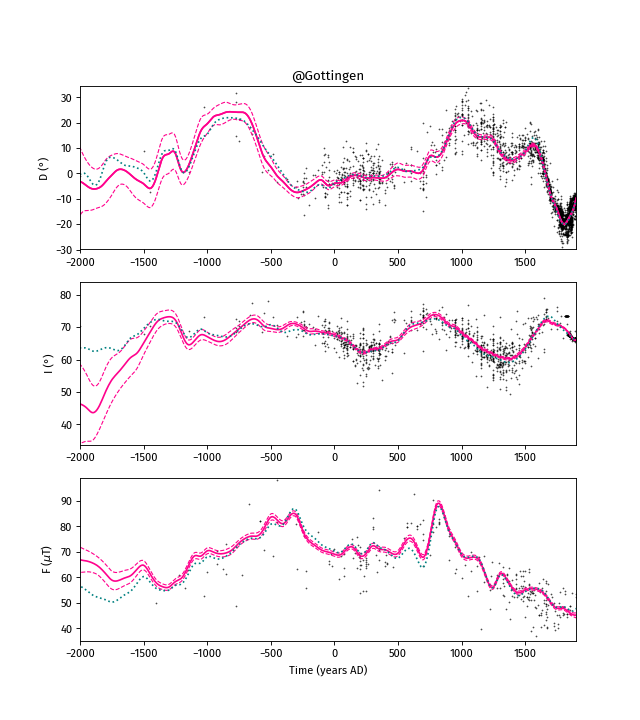

In [27]:
locations = [
    (48.8, 2.35, "Paris"),
    (42.69, 23.32, "Sofia"),
    (51.54, 9.92, "Gottingen"),
]

for loc in locations:
    location_curves(*loc).savefig(savepath+"/"+loc[2]+".png")